In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import json
from pathlib import Path

# ============================================================================
# Paper-Ready Styling Configuration
# ============================================================================
plt.rcParams.update({
    # Font settings (use LaTeX-like fonts)
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    
    # Figure settings
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    
    # Line and grid settings
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    
    # Remove top and right spines for cleaner look
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Color palette (colorblind-friendly)
COLORS = {
    'gpt4': '#1f77b4',      # Blue
    'base': '#ff7f0e',      # Orange
    'sft': '#2ca02c',       # Green
    'dpo': '#d62728',       # Red
    'gray': '#7f7f7f',      # Gray
}

# Project root
PROJECT_ROOT = Path('..').resolve()
print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/carloschreiber/Desktop/Uni/Quarter 1/CS229 - Machine Learning/Sarcasm


## 1. Load Results

In [153]:
# Load comparative results
results_path = PROJECT_ROOT / 'comparative_results.json'

if results_path.exists():
    with open(results_path) as f:
        results = json.load(f)
    print(f"Loaded results from: {results_path}")
    print(f"Evaluation date: {results.get('evaluation_date', 'N/A')}")
    print(f"Test set size: {results.get('test_set_size', 'N/A')}")
else:
    print(f"Results file not found at {results_path}")
    print("Run 'python scripts/evaluate_all_stages.py' first")
    results = None

Loaded results from: /Users/carloschreiber/Desktop/Uni/Quarter 1/CS229 - Machine Learning/Sarcasm/comparative_results.json
Evaluation date: 2025-12-01T15:50:40.498627
Test set size: 1000


## 2. Model Comparison Chart

In [154]:
if results and 'models' in results:
    # Create DataFrame from results
    models_df = pd.DataFrame(results['models'])
    
    # Clean model names for table
    name_mapping = {
        'gpt-4 (Zero-shot)': 'GPT-4 (Zero-shot)',
        'Base Model (Zero-shot)': 'Qwen-0.5B (Zero-shot)',
        'SFT Model (GEN)': 'Qwen-0.5B + SFT',
        'DPO Model (GEN Enhanced)': 'Qwen-0.5B + SFT + DPO'
    }
    
    # Create display table
    display_df = pd.DataFrame({
        'Model': models_df['model_name'].map(name_mapping).fillna(models_df['model_name']),
        'Accuracy': models_df['accuracy'].apply(lambda x: f"{x*100:.1f}"),
        'Precision': models_df['precision'].apply(lambda x: f"{x*100:.1f}"),
        'Recall': models_df['recall'].apply(lambda x: f"{x*100:.1f}"),
        'F1': models_df['f1_score'].apply(lambda x: f"{x*100:.1f}"),
    })
    
    # Print LaTeX table for paper
    print("=" * 70)
    print("LaTeX Table (copy to paper):")
    print("=" * 70)
    print(r"\begin{table}[h]")
    print(r"\centering")
    print(r"\caption{Model performance comparison on GEN-sarc-notsarc test set}")
    print(r"\label{tab:results}")
    print(r"\begin{tabular}{lcccc}")
    print(r"\toprule")
    print(r"Model & Accuracy & Precision & Recall & F1 \\")
    print(r"\midrule")
    for _, row in display_df.iterrows():
        print(f"{row['Model']} & {row['Accuracy']} & {row['Precision']} & {row['Recall']} & {row['F1']} \\\\")
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\end{table}")
    print("=" * 70)
    
    # Also display nicely
    print("\n📊 Results Summary:\n")
    display(display_df.style.set_properties(**{'text-align': 'center'})
            .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

LaTeX Table (copy to paper):
\begin{table}[h]
\centering
\caption{Model performance comparison on GEN-sarc-notsarc test set}
\label{tab:results}
\begin{tabular}{lcccc}
\toprule
Model & Accuracy & Precision & Recall & F1 \\
\midrule
GPT-4 (Zero-shot) & 79.7 & 82.9 & 75.0 & 78.8 \\
Qwen-0.5B (Zero-shot) & 49.6 & 49.5 & 36.8 & 42.2 \\
Qwen-0.5B + SFT & 69.8 & 67.6 & 76.0 & 71.6 \\
Qwen-0.5B + SFT + DPO & 73.8 & 69.8 & 84.0 & 76.2 \\
\bottomrule
\end{tabular}
\end{table}

📊 Results Summary:



,Model,Accuracy,Precision,Recall,F1
0,GPT-4 (Zero-shot),79.7,82.9,75.0,78.8
1,Qwen-0.5B (Zero-shot),49.6,49.5,36.8,42.2
2,Qwen-0.5B + SFT,69.8,67.6,76.0,71.6
3,Qwen-0.5B + SFT + DPO,73.8,69.8,84.0,76.2


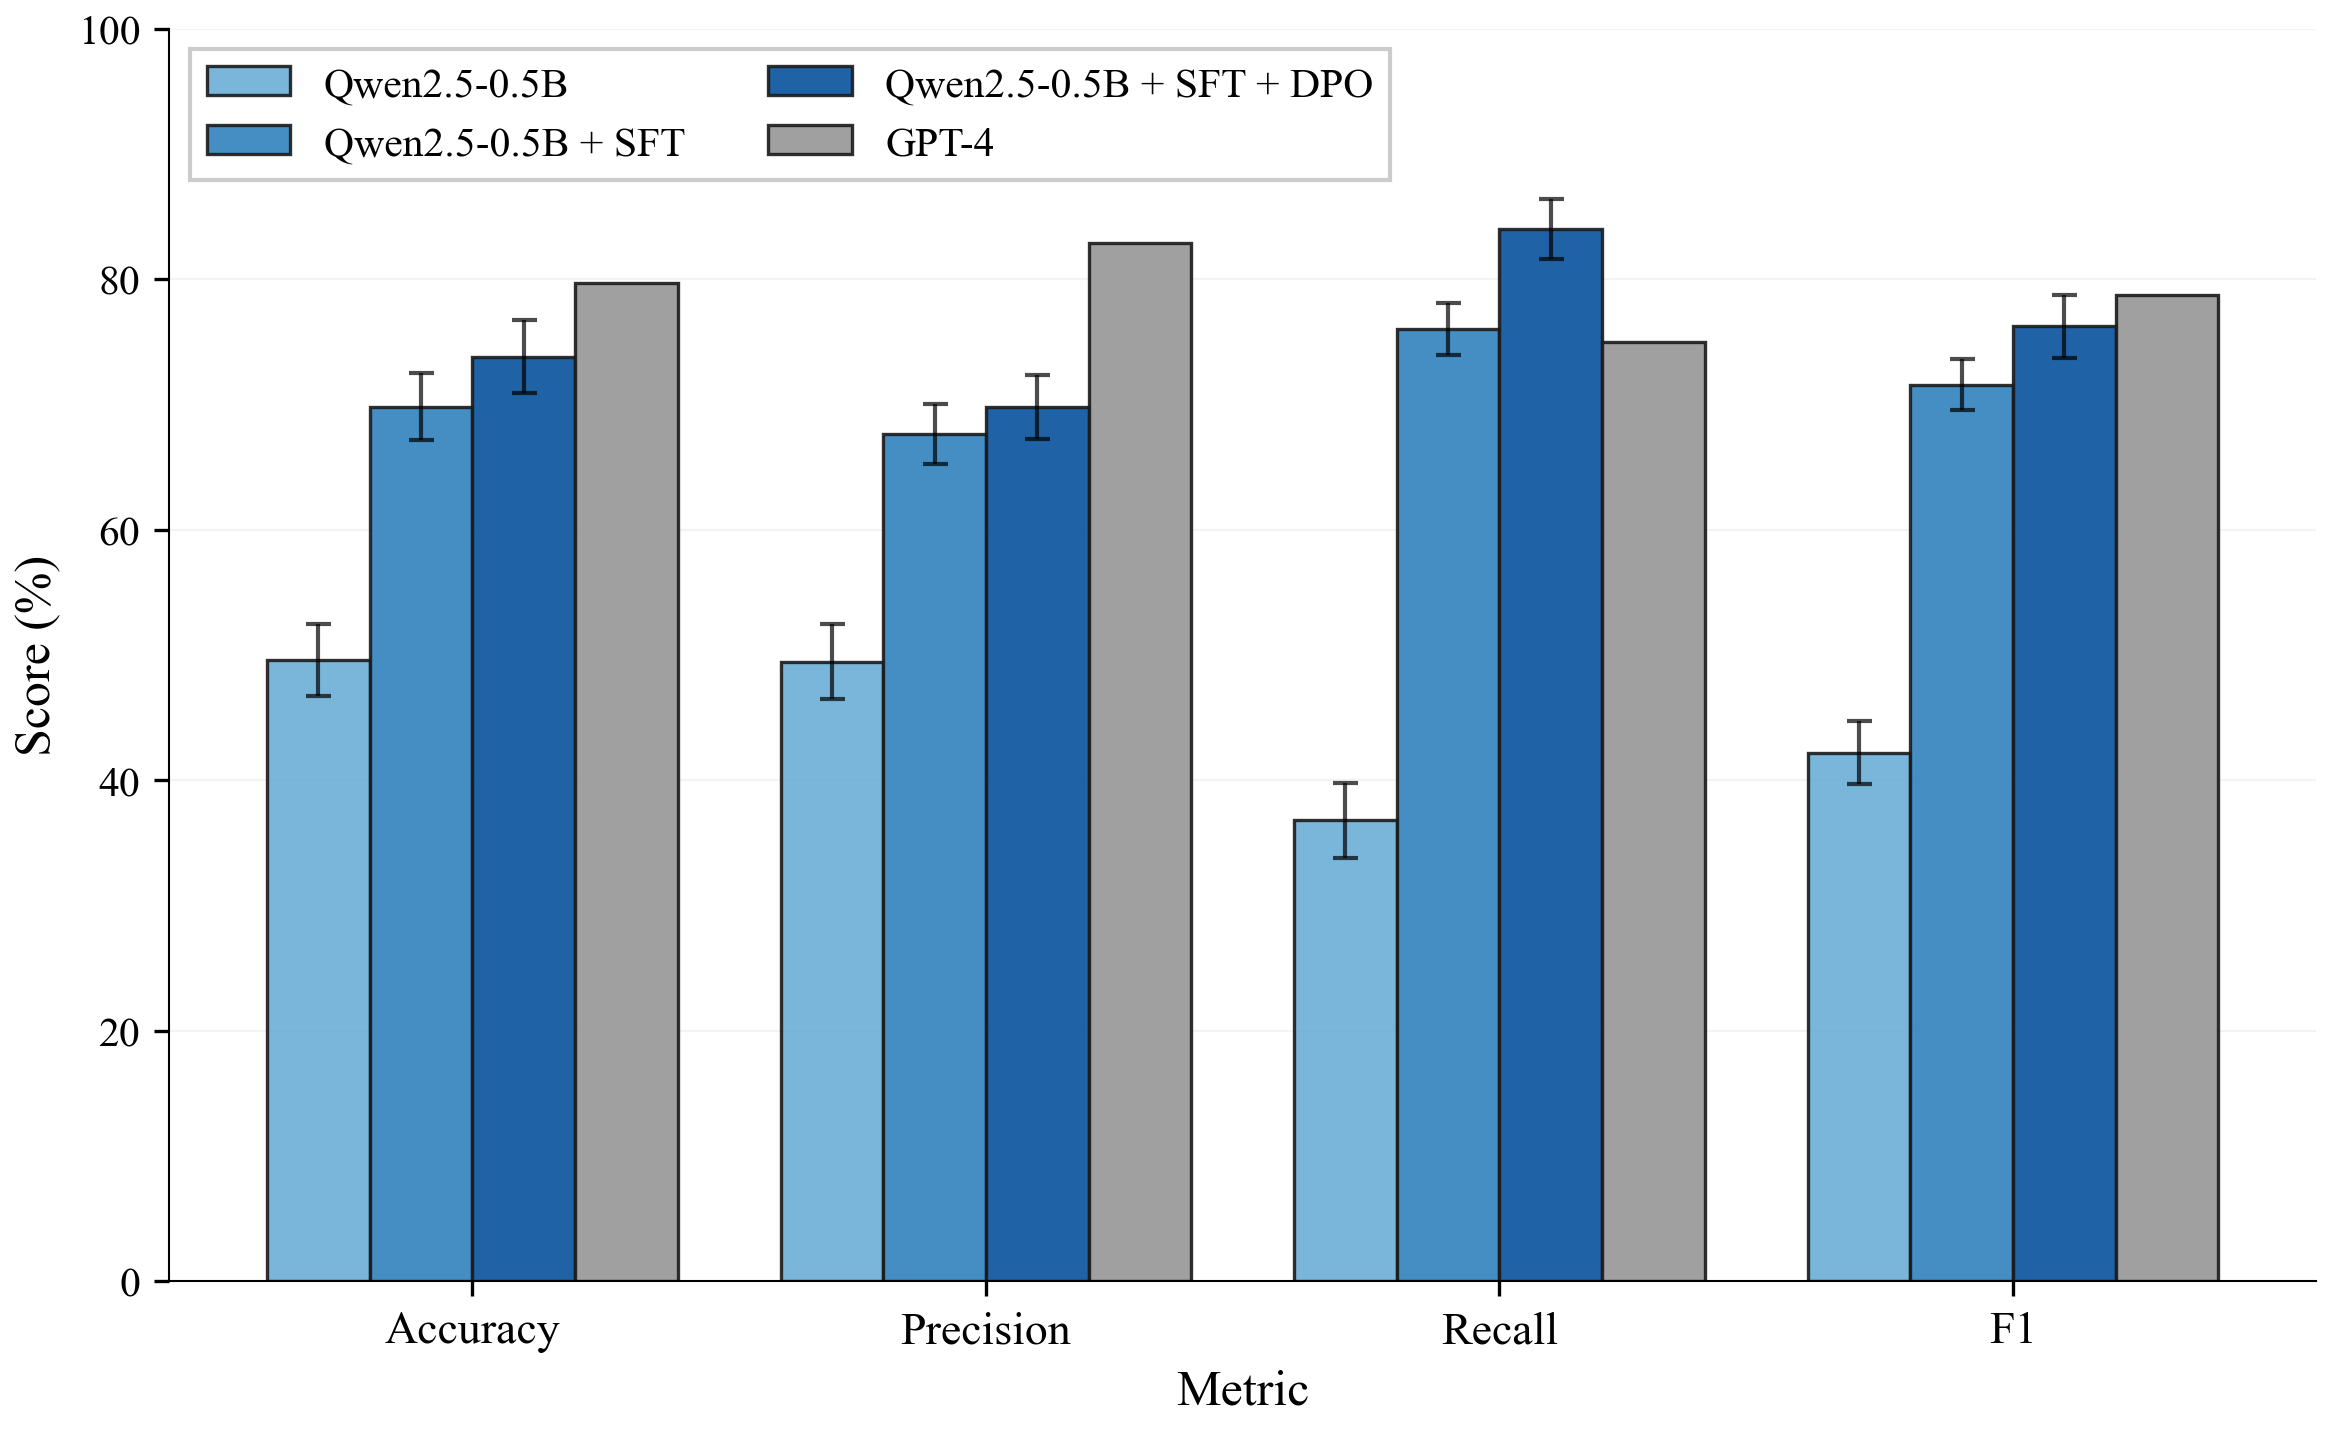

✓ Saved: fig_model_comparison.pdf/png


In [155]:
if results and 'models' in results:
    models_df = pd.DataFrame(results['models'])
    
    # Reorder: Qwen → SFT → DPO → GPT-4
    order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (GEN Enhanced)', 'gpt-4 (Zero-shot)']
    models_df['sort_order'] = models_df['model_name'].apply(lambda x: order.index(x) if x in order else 99)
    models_df = models_df.sort_values('sort_order').reset_index(drop=True)
    
    # Clean model names for paper (Qwen2.5)
    name_mapping = {
        'Base Model (Zero-shot)': 'Qwen2.5-0.5B',
        'SFT Model (GEN)': 'Qwen2.5-0.5B + SFT',
        'DPO Model (GEN Enhanced)': 'Qwen2.5-0.5B + SFT + DPO',
        'gpt-4 (Zero-shot)': 'GPT-4'
    }
    models_df['clean_name'] = models_df['model_name'].map(name_mapping).fillna(models_df['model_name'])
    
    # Variance data from 5 runs with 250 samples each
    # Standard errors: BASE, SFT, DPO (GPT-4 has no variance as it's deterministic API)
    variance_data = {
        'Qwen2.5-0.5B': {
            'accuracy': 2.89,
            'precision': 2.97,
            'recall': 3.00,
            'f1_score': 2.55
        },
        'Qwen2.5-0.5B + SFT': {
            'accuracy': 2.66,
            'precision': 2.40,
            'recall': 2.09,
            'f1_score': 2.02
        },
        'Qwen2.5-0.5B + SFT + DPO': {
            'accuracy': 2.89,
            'precision': 2.53,
            'recall': 2.42,
            'f1_score': 2.53
        },
        'GPT-4': {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0
        }
    }
    
    # Create figure - transposed layout (metrics on x-axis, models as bars)
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Metrics on x-axis
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1']
    x = np.arange(len(metrics))
    
    # Models as different bars
    n_models = len(models_df)
    width = 0.2
    
    # Colors for each model
    model_colors = ['#6baed6', '#3182bd', '#08519c', '#969696']  # Blues for our models, gray for GPT-4
    
    # Plot bars for each model with error bars
    for i, (idx, row) in enumerate(models_df.iterrows()):
        values = [row[metric] * 100 for metric in metrics]
        offset = (i - n_models/2 + 0.5) * width
        
        # Get error bars for this model
        model_name = row['clean_name']
        errors = [variance_data[model_name][metric] for metric in metrics]
        
        # Only show error bars for non-GPT-4 models
        if model_name == 'GPT-4':
            bars = ax.bar(x + offset, values, width, 
                         label=row['clean_name'], 
                         color=model_colors[i], 
                         alpha=0.9, 
                         edgecolor='#1a1a1a', 
                         linewidth=0.8)
        else:
            bars = ax.bar(x + offset, values, width, 
                         yerr=errors,
                         capsize=3,
                         error_kw={'elinewidth': 1, 'capthick': 1, 'alpha': 0.7},
                         label=row['clean_name'], 
                         color=model_colors[i], 
                         alpha=0.9, 
                         edgecolor='#1a1a1a', 
                         linewidth=0.8)
    
    # Styling
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='medium')
    ax.set_xlabel('Metric', fontsize=12, fontweight='medium')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels, fontsize=11)
    ax.legend(loc='upper left', ncol=2, frameon=True, fancybox=False, 
              edgecolor='#cccccc', framealpha=1, fontsize=10)
    ax.set_ylim(0, 100)
    
    # Grid
    ax.yaxis.grid(True, linestyle='-', alpha=0.15, zorder=0)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_model_comparison.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: fig_model_comparison.pdf/png")


## F1 Score Comparison (In-Distribution - IAC-V2/GEN)

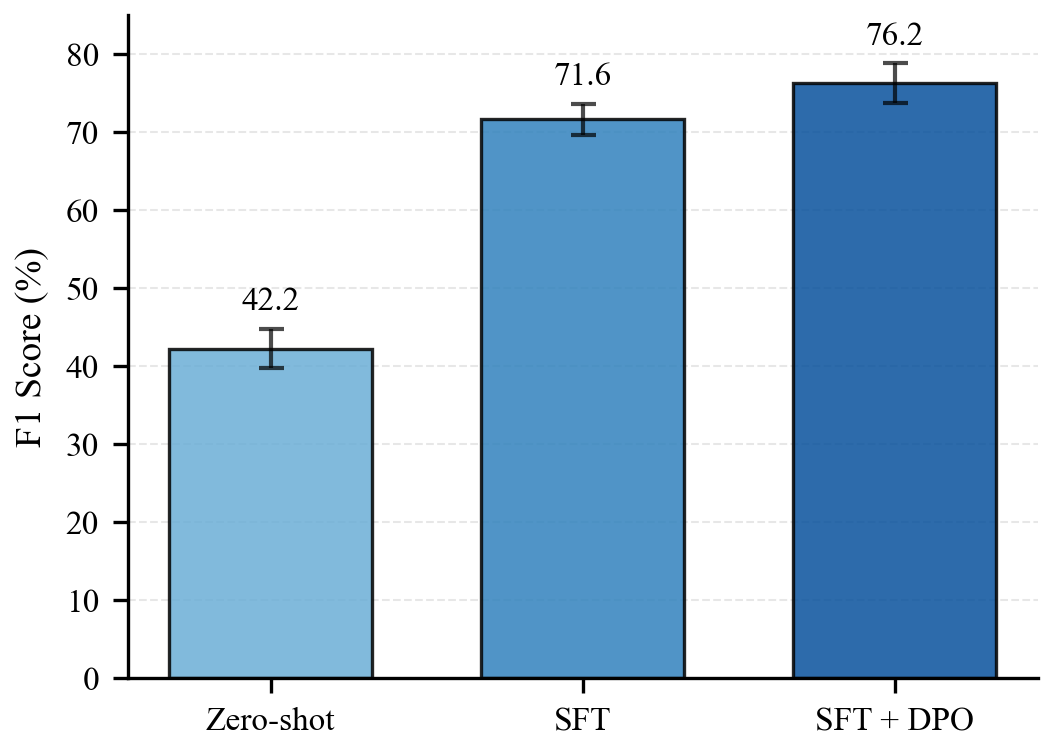

✓ Saved: fig_f1_comparison.pdf/png
  SFT gain: +29.4 F1
  DPO gain: +4.7 F1


In [156]:
# F1 Score comparison across models on IAC-V2 (in-distribution - GEN dataset)
# SFT achieves the dominant gain over zero-shot (+29.4 F1), 
# while DPO provides incremental improvement (+4.6 F1)

if results and 'models' in results:
    models_df_gen = pd.DataFrame(results['models'])
    
    # Filter to relevant models for comparison
    order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (GEN Enhanced)']
    models_df_gen = models_df_gen[models_df_gen['model_name'].isin(order)].copy()
    models_df_gen['sort_order'] = models_df_gen['model_name'].apply(lambda x: order.index(x))
    models_df_gen = models_df_gen.sort_values('sort_order').reset_index(drop=True)
    
    # Clean model names
    name_mapping = {
        'Base Model (Zero-shot)': 'Zero-shot',
        'SFT Model (GEN)': 'SFT',
        'DPO Model (GEN Enhanced)': 'SFT + DPO'
    }
    models_df_gen['clean_name'] = models_df_gen['model_name'].map(name_mapping)
    
    # Extract F1 scores
    f1_scores = models_df_gen['f1_score'].values * 100
    labels = models_df_gen['clean_name'].values
    
    # F1 error bars from variance data
    f1_errors = [2.55, 2.02, 2.53]  # Base, SFT, DPO
    
    # Calculate improvements
    sft_gain = f1_scores[1] - f1_scores[0]
    dpo_gain = f1_scores[2] - f1_scores[1]
    
    # Create figure - IEEE two-column format
    fig_f1_comparison, ax = plt.subplots(figsize=(3.5, 2.5))
    
    # Blue color scheme matching other figures
    colors = ['#6baed6', '#3182bd', '#08519c']
    
    x_pos = np.arange(len(labels))
    bars = ax.bar(x_pos, f1_scores, yerr=f1_errors, capsize=3,
                  error_kw={'elinewidth': 1, 'capthick': 1, 'alpha': 0.7},
                  color=colors, alpha=0.85, 
                  edgecolor='black', linewidth=0.8, width=0.65)
    
    # Add value labels on bars (moved up to avoid error bar collision)
    for i, (bar, f1, error) in enumerate(zip(bars, f1_scores, f1_errors)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + error + 1.5,
                f'{f1:.1f}',
                ha='center', va='bottom', fontsize=8, fontweight='normal')
    
    # Styling - clean and minimal
    ax.set_ylabel('F1 Score (%)', fontsize=9)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_ylim(0, 85)
    
    # Minimal grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=8, width=0.8)
    
    plt.tight_layout(pad=0.3)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_f1_comparison.pdf', 
                format='pdf', bbox_inches='tight', dpi=600)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_f1_comparison.png', 
                dpi=600, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: fig_f1_comparison.pdf/png")
    print(f"  SFT gain: +{sft_gain:.1f} F1")
    print(f"  DPO gain: +{dpo_gain:.1f} F1")


## In-Distribution vs Out-of-Distribution Performance

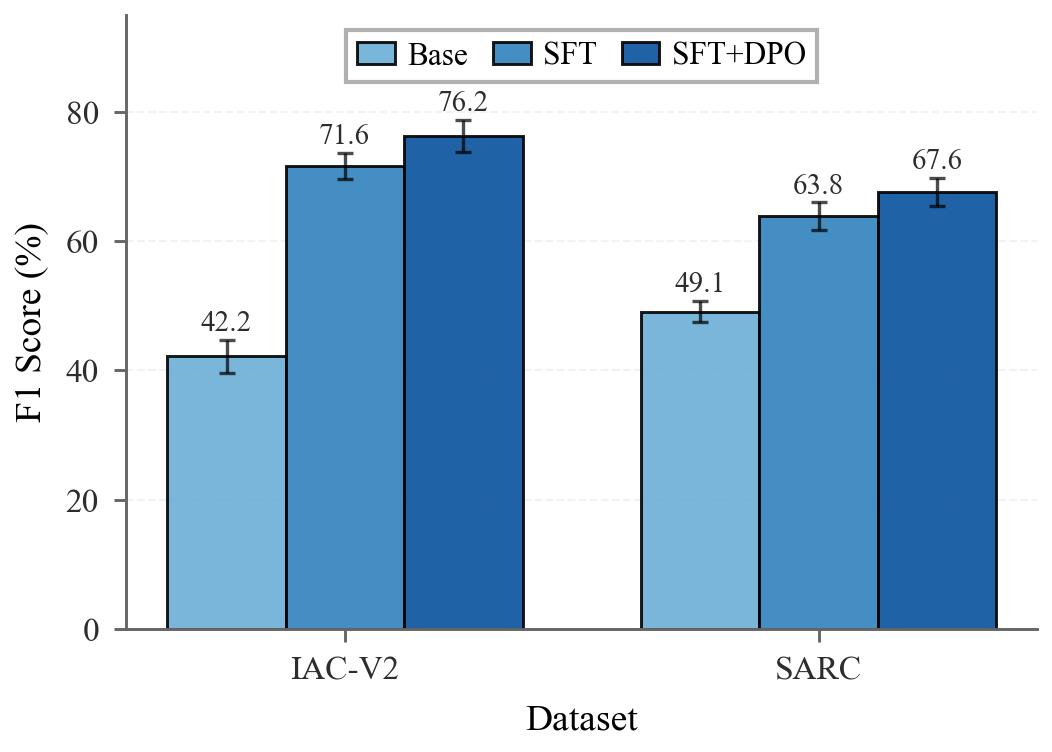

✓ Saved: fig_id_vs_ood.pdf/png

Domain Shift Analysis:
  Base: --6.9 F1 (IAC-V2: 42.2% → SARC: 49.1%)
  SFT: -7.7 F1 (IAC-V2: 71.6% → SARC: 63.8%)
  SFT+DPO: -8.7 F1 (IAC-V2: 76.2% → SARC: 67.6%)


In [157]:
# In-distribution (IAC-V2) vs out-of-distribution (SARC) performance
# Domain shift causes a 7-8 point F1 decline for SFT, 
# but SFT+DPO narrows the gap through preference-based hardening

if results and 'models' in results and sarc_results and 'models' in sarc_results:
    # Prepare IAC-V2 (in-distribution) data
    models_df_gen = pd.DataFrame(results['models'])
    gen_order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (GEN Enhanced)']
    models_df_gen = models_df_gen[models_df_gen['model_name'].isin(gen_order)].copy()
    models_df_gen['sort_order'] = models_df_gen['model_name'].apply(lambda x: gen_order.index(x))
    models_df_gen = models_df_gen.sort_values('sort_order').reset_index(drop=True)
    
    # Prepare SARC (out-of-distribution) data
    models_df_sarc = pd.DataFrame(sarc_results['models'])
    sarc_order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (Mistakes)']
    sarc_mapping = {
        'Base Model (Zero-shot)': 'Base Model (Zero-shot)',
        'SFT Model (GEN)': 'SFT Model (GEN)',
        'DPO Model (Mistakes)': 'DPO Model (GEN Enhanced)'  # Map to same name for comparison
    }
    models_df_sarc = models_df_sarc[models_df_sarc['model_name'].isin(sarc_order)].copy()
    models_df_sarc['model_name'] = models_df_sarc['model_name'].map(sarc_mapping)
    models_df_sarc['sort_order'] = models_df_sarc['model_name'].apply(lambda x: gen_order.index(x))
    models_df_sarc = models_df_sarc.sort_values('sort_order').reset_index(drop=True)
    
    # Extract F1 scores
    f1_gen = models_df_gen['f1_score'].values * 100
    f1_sarc = models_df_sarc['f1_score'].values * 100
    
    # F1 error bars from variance analysis
    f1_errors_gen = [2.55, 2.02, 2.53]  # Base, SFT, DPO on IAC-V2/GEN
    f1_errors_sarc = [1.66, 2.16, 2.16]  # Base, SFT, DPO on SARC
    
    # Calculate domain shift gaps
    gaps = f1_gen - f1_sarc
    
    # Create figure - IEEE two-column format with cleaner design
    fig_id_vs_ood, ax = plt.subplots(figsize=(3.5, 2.5))
    
    # X-axis: datasets (IAC-V2 and SARC)
    datasets = ['IAC-V2', 'SARC']
    x_pos = np.arange(len(datasets))
    width = 0.25  # Width of each bar
    
    # Model stages with blue color scheme
    stage_labels = ['Base', 'SFT', 'SFT+DPO']
    colors = ['#6baed6', '#3182bd', '#08519c']  # Light blue → medium blue → dark blue
    
    # Plot bars for each stage with error bars
    for i in range(3):
        # Offset for each stage within a dataset group
        offset = (i - 1) * width
        values = [f1_gen[i], f1_sarc[i]]
        errors = [f1_errors_gen[i], f1_errors_sarc[i]]
        
        bars = ax.bar(x_pos + offset, values, width, yerr=errors, capsize=2,
                     error_kw={'elinewidth': 0.8, 'capthick': 0.8, 'alpha': 0.7},
                     label=stage_labels[i],
                     color=colors[i], alpha=0.9, edgecolor='black', linewidth=0.7)
        
        # Add value labels on bars (positioned above error bars)
        for bar, val, err in zip(bars, values, errors):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + err + 0.5,
                    f'{val:.1f}',
                    ha='center', va='bottom', fontsize=7, fontweight='normal', color='#2d2d2d')
    
    # Styling - cleaner and more minimal
    ax.set_ylabel('F1 Score (%)', fontsize=9)
    ax.set_xlabel('Dataset', fontsize=9)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(datasets, fontsize=9)
    ax.set_ylim(0, 95)  # Tighter y-axis for cleaner look
    
    # Cleaner legend - horizontal layout at the top
    ax.legend(loc='upper center', frameon=True, fancybox=False, 
              edgecolor='#b0b0b0', framealpha=1, fontsize=7.5, 
              handlelength=1.2, handletextpad=0.4, borderpad=0.35,
              columnspacing=0.8, ncol=3)  # Changed to ncol=3 for horizontal layout
    
    # Lighter, cleaner grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.25, linewidth=0.5, zorder=0, color='#cccccc')
    ax.set_axisbelow(True)
    
    # Clean spines with lighter weight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.7)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_linewidth(0.7)
    ax.spines['bottom'].set_color('#666666')
    
    # Adjust tick parameters for cleaner look
    ax.tick_params(axis='both', which='major', labelsize=8, width=0.7, 
                   length=3, color='#666666', labelcolor='#2d2d2d')
    
    plt.tight_layout(pad=0.3)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_id_vs_ood.pdf', 
                format='pdf', bbox_inches='tight', dpi=600)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_id_vs_ood.png', 
                dpi=600, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: fig_id_vs_ood.pdf/png")
    print(f"\nDomain Shift Analysis:")
    for i, (stage, gap) in enumerate(zip(stage_labels, gaps)):
        print(f"  {stage}: -{gap:.1f} F1 (IAC-V2: {f1_gen[i]:.1f}% → SARC: {f1_sarc[i]:.1f}%)")


## 2.5. Model Comparison on SARC Dataset

In [158]:
# Load SARC comparative results
sarc_results_path = PROJECT_ROOT / 'comparative_results_sarc.json'

if sarc_results_path.exists():
    with open(sarc_results_path, 'r') as f:
        sarc_results = json.load(f)
    
    print("SARC Comparative Results Loaded")
    print(f"Dataset: {sarc_results['test_set']}")
    print(f"Sample size: {sarc_results['sample_size']}")
    print(f"Seed: {sarc_results['eval_seed']}")
else:
    print(f"⚠️  SARC results not found at {sarc_results_path}")
    print("Run: python scripts/Qwen2.5/evaluate_all_stages_sarc.py")
    sarc_results = None

SARC Comparative Results Loaded
Dataset: SARC train-balanced-sarcasm.csv
Sample size: 500
Seed: 10


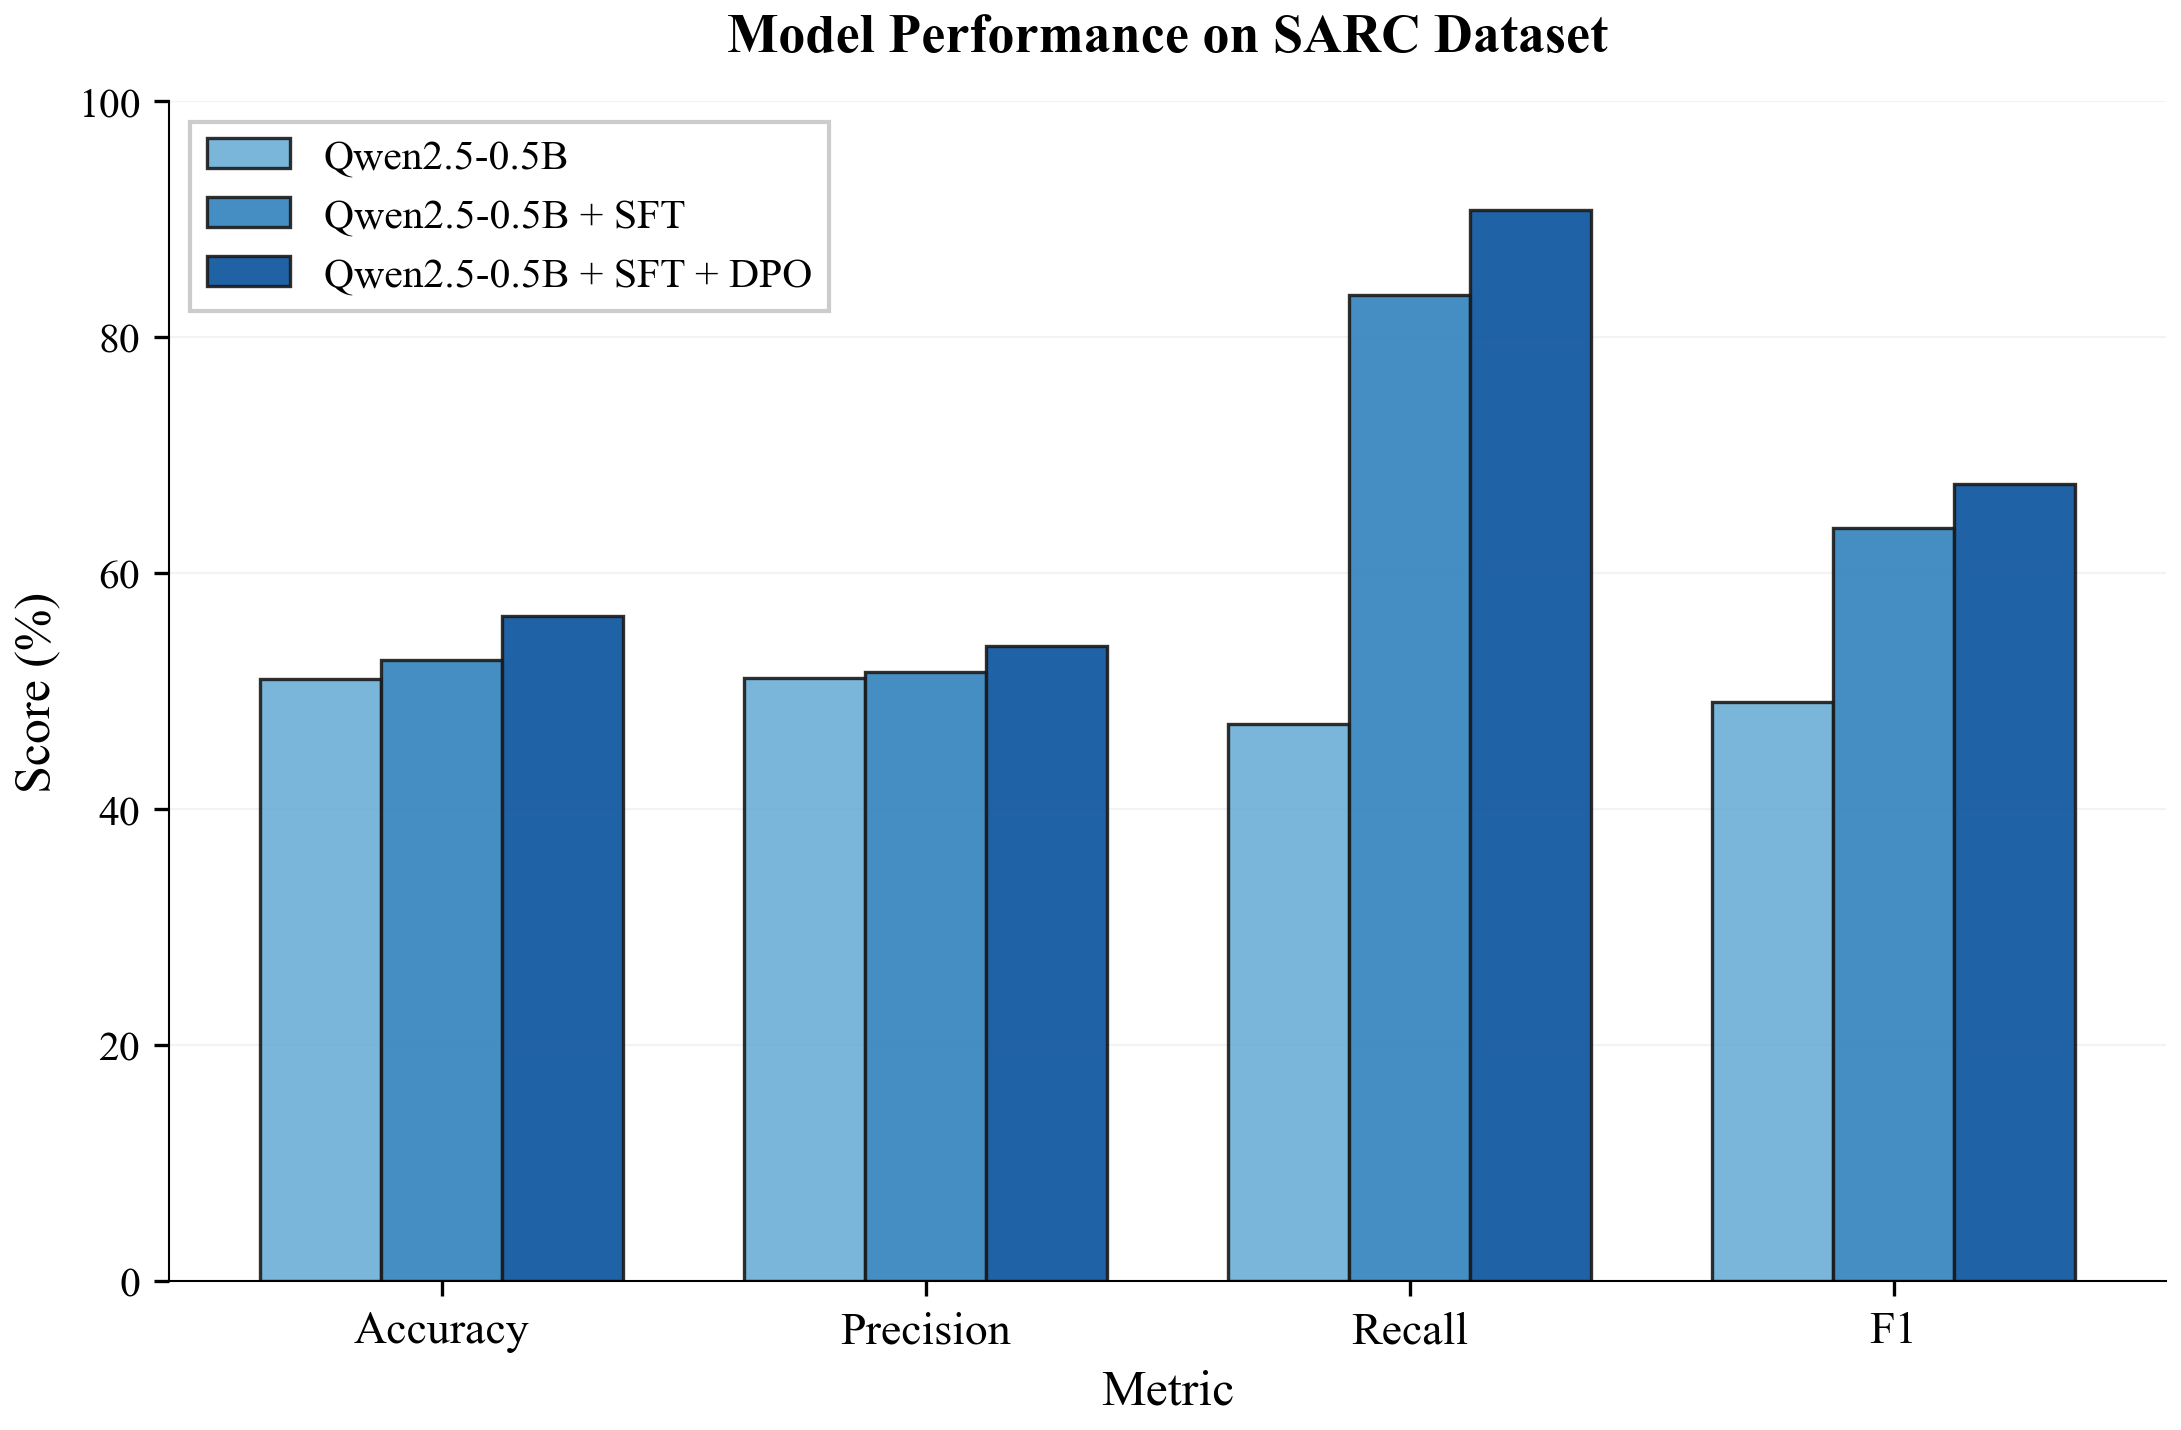

✓ Saved: fig_model_comparison_sarc.pdf/png


In [159]:
if sarc_results and 'models' in sarc_results:
    models_df_sarc = pd.DataFrame(sarc_results['models'])
    
    # Reorder: Qwen → SFT → DPO
    order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (Mistakes)']
    models_df_sarc['sort_order'] = models_df_sarc['model_name'].apply(lambda x: order.index(x) if x in order else 99)
    models_df_sarc = models_df_sarc.sort_values('sort_order').reset_index(drop=True)
    
    # Clean model names for paper (Qwen2.5)
    name_mapping = {
        'Base Model (Zero-shot)': 'Qwen2.5-0.5B',
        'SFT Model (GEN)': 'Qwen2.5-0.5B + SFT',
        'DPO Model (Mistakes)': 'Qwen2.5-0.5B + SFT + DPO'
    }
    models_df_sarc['clean_name'] = models_df_sarc['model_name'].map(name_mapping).fillna(models_df_sarc['model_name'])
    
    # Create figure - transposed layout (metrics on x-axis, models as bars)
    fig, ax = plt.subplots(figsize=(7.5, 5))
    
    # Metrics on x-axis
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1']
    x = np.arange(len(metrics))
    
    # Models as different bars
    n_models = len(models_df_sarc)
    width = 0.25
    
    # Colors for each model (blues progression)
    model_colors = ['#6baed6', '#3182bd', '#08519c']  # Light → medium → dark blue
    
    # Plot bars for each model
    for i, (idx, row) in enumerate(models_df_sarc.iterrows()):
        values = [row[metric] * 100 for metric in metrics]
        offset = (i - n_models/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, 
                     label=row['clean_name'], 
                     color=model_colors[i], 
                     alpha=0.9, 
                     edgecolor='#1a1a1a', 
                     linewidth=0.8)
    
    # Styling
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='medium')
    ax.set_xlabel('Metric', fontsize=12, fontweight='medium')
    ax.set_title('Model Performance on SARC Dataset', fontsize=13, fontweight='bold', pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels, fontsize=11)
    ax.legend(loc='upper left', ncol=1, frameon=True, fancybox=False, 
              edgecolor='#cccccc', framealpha=1, fontsize=10)
    ax.set_ylim(0, 100)
    
    # Grid
    ax.yaxis.grid(True, linestyle='-', alpha=0.15, zorder=0)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_model_comparison_sarc.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_model_comparison_sarc.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: fig_model_comparison_sarc.pdf/png")

## 2.6. In-Distribution vs Out-of-Distribution Performance

## 3. Accuracy Progression

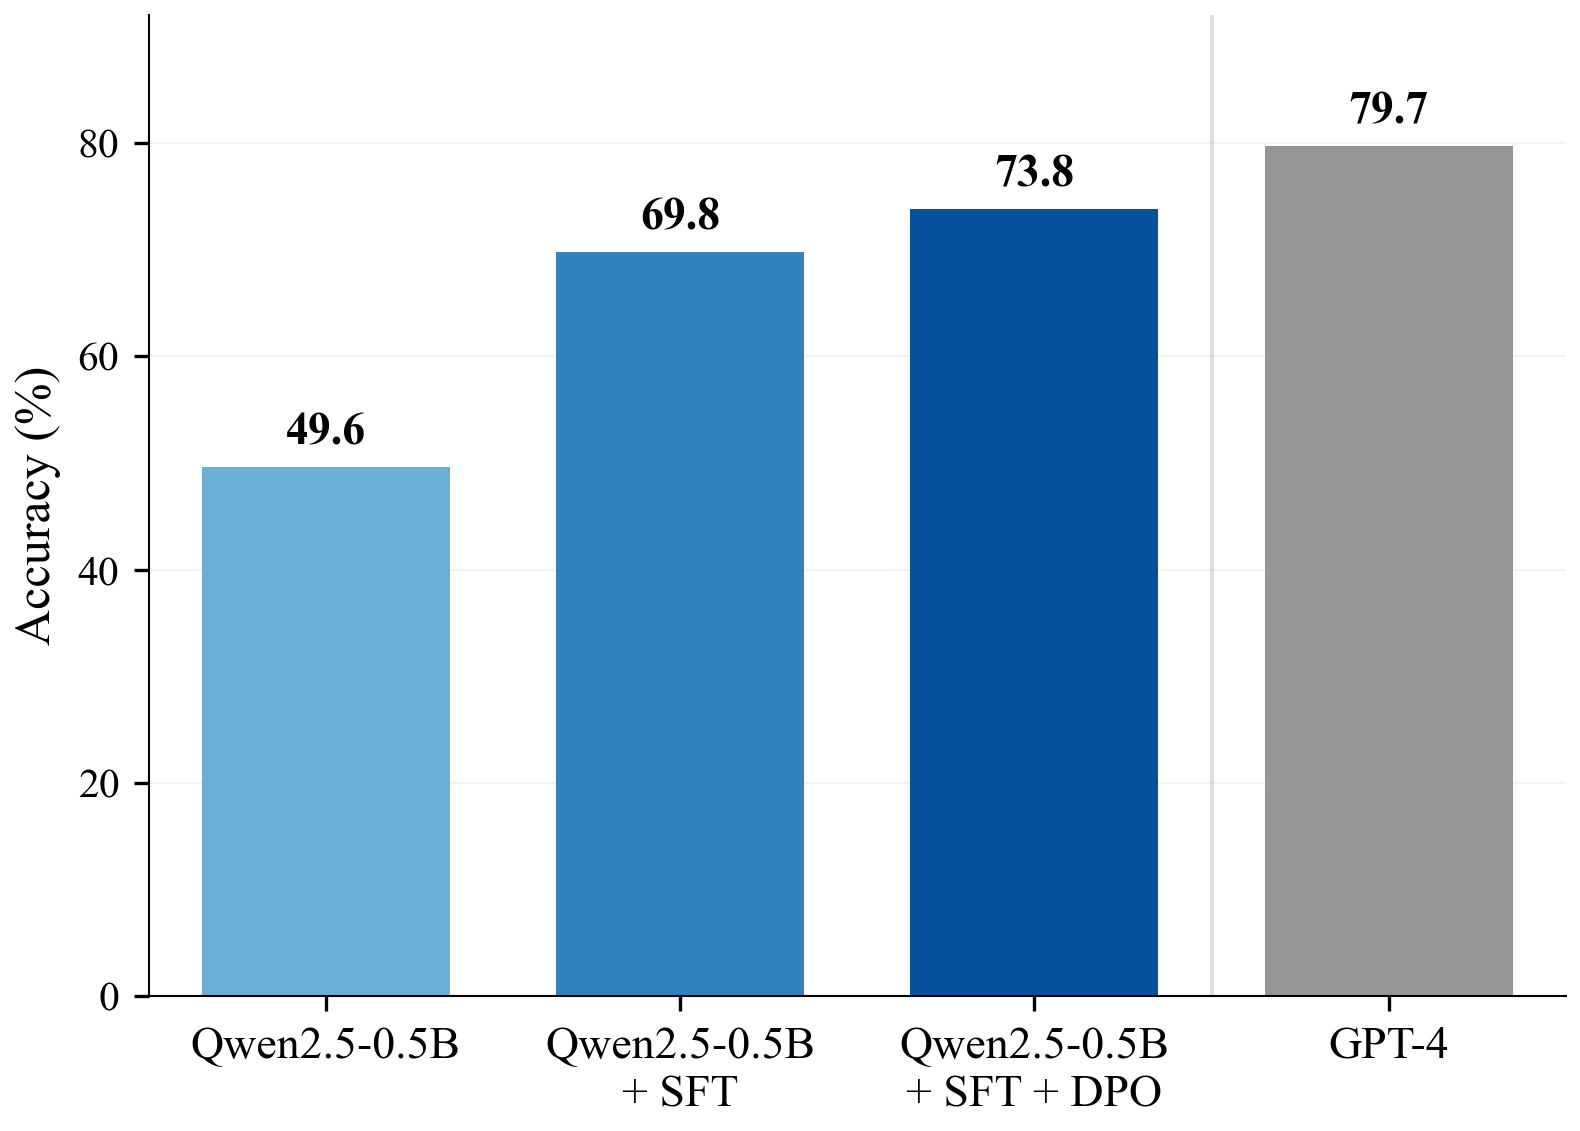


SUGGESTED FIGURE CAPTION:

Figure X: Sarcasm detection accuracy on the GEN-sarc-notsarc test set 
(n=500, balanced). Left: our fine-tuning pipeline showing Qwen2.5-0.5B 
base model, after supervised fine-tuning (SFT), and after Direct 
Preference Optimization (DPO). Right: GPT-4 zero-shot baseline for 
comparison. Our fine-tuned 0.49B parameter model approaches GPT-4 
performance while being ~3000× smaller.

✓ Saved: fig_accuracy_progression.pdf/png


In [160]:
if results and 'models' in results:
    models_df = pd.DataFrame(results['models'])
    
    # Reorder: Our progression (Base → SFT → DPO), then GPT-4 as comparison
    order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (GEN Enhanced)', 'gpt-4 (Zero-shot)']
    models_df['sort_order'] = models_df['model_name'].apply(lambda x: order.index(x) if x in order else 99)
    models_df = models_df.sort_values('sort_order').reset_index(drop=True)
    
    # Professional model names (Qwen 2.5)
    name_mapping = {
        'Base Model (Zero-shot)': 'Qwen2.5-0.5B',
        'SFT Model (GEN)': 'Qwen2.5-0.5B\n+ SFT',
        'DPO Model (GEN Enhanced)': 'Qwen2.5-0.5B\n+ SFT + DPO',
        'gpt-4 (Zero-shot)': 'GPT-4'
    }
    display_names = [name_mapping.get(n, n) for n in models_df['model_name']]
    
    fig, ax = plt.subplots(figsize=(5.5, 4))
    
    accuracies = models_df['accuracy'].values * 100
    x = np.arange(len(accuracies))
    
    # Colorblind-friendly palette: blues for our models, gray for GPT-4
    colors = ['#6baed6', '#3182bd', '#08519c', '#969696']  # Light blue → dark blue, then gray
    
    # Clean bars with no edge color for modern look
    bars = ax.bar(x, accuracies, color=colors, edgecolor='none', width=0.7)
    
    # Value labels on top of bars
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.2,
               f'{acc:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Axis formatting
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='medium')
    ax.set_xticks(x)
    ax.set_xticklabels(display_names, fontsize=11)
    ax.set_ylim(0, 92)
    ax.set_xlim(-0.5, len(x) - 0.5)
    
    # Subtle separator before GPT-4
    ax.axvline(x=2.5, color='#e0e0e0', linestyle='-', linewidth=1, zorder=0)
    
    # Clean grid (y-axis only)
    ax.yaxis.grid(True, linestyle='-', alpha=0.15, zorder=0)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_accuracy_progression.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_accuracy_progression.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print suggested caption
    print("\n" + "="*70)
    print("SUGGESTED FIGURE CAPTION:")
    print("="*70)
    print("""
Figure X: Sarcasm detection accuracy on the GEN-sarc-notsarc test set 
(n=500, balanced). Left: our fine-tuning pipeline showing Qwen2.5-0.5B 
base model, after supervised fine-tuning (SFT), and after Direct 
Preference Optimization (DPO). Right: GPT-4 zero-shot baseline for 
comparison. Our fine-tuned 0.49B parameter model approaches GPT-4 
performance while being ~3000× smaller.
""")
    print("="*70)
    print("✓ Saved: fig_accuracy_progression.pdf/png")

## 4. Confusion Matrix Comparison

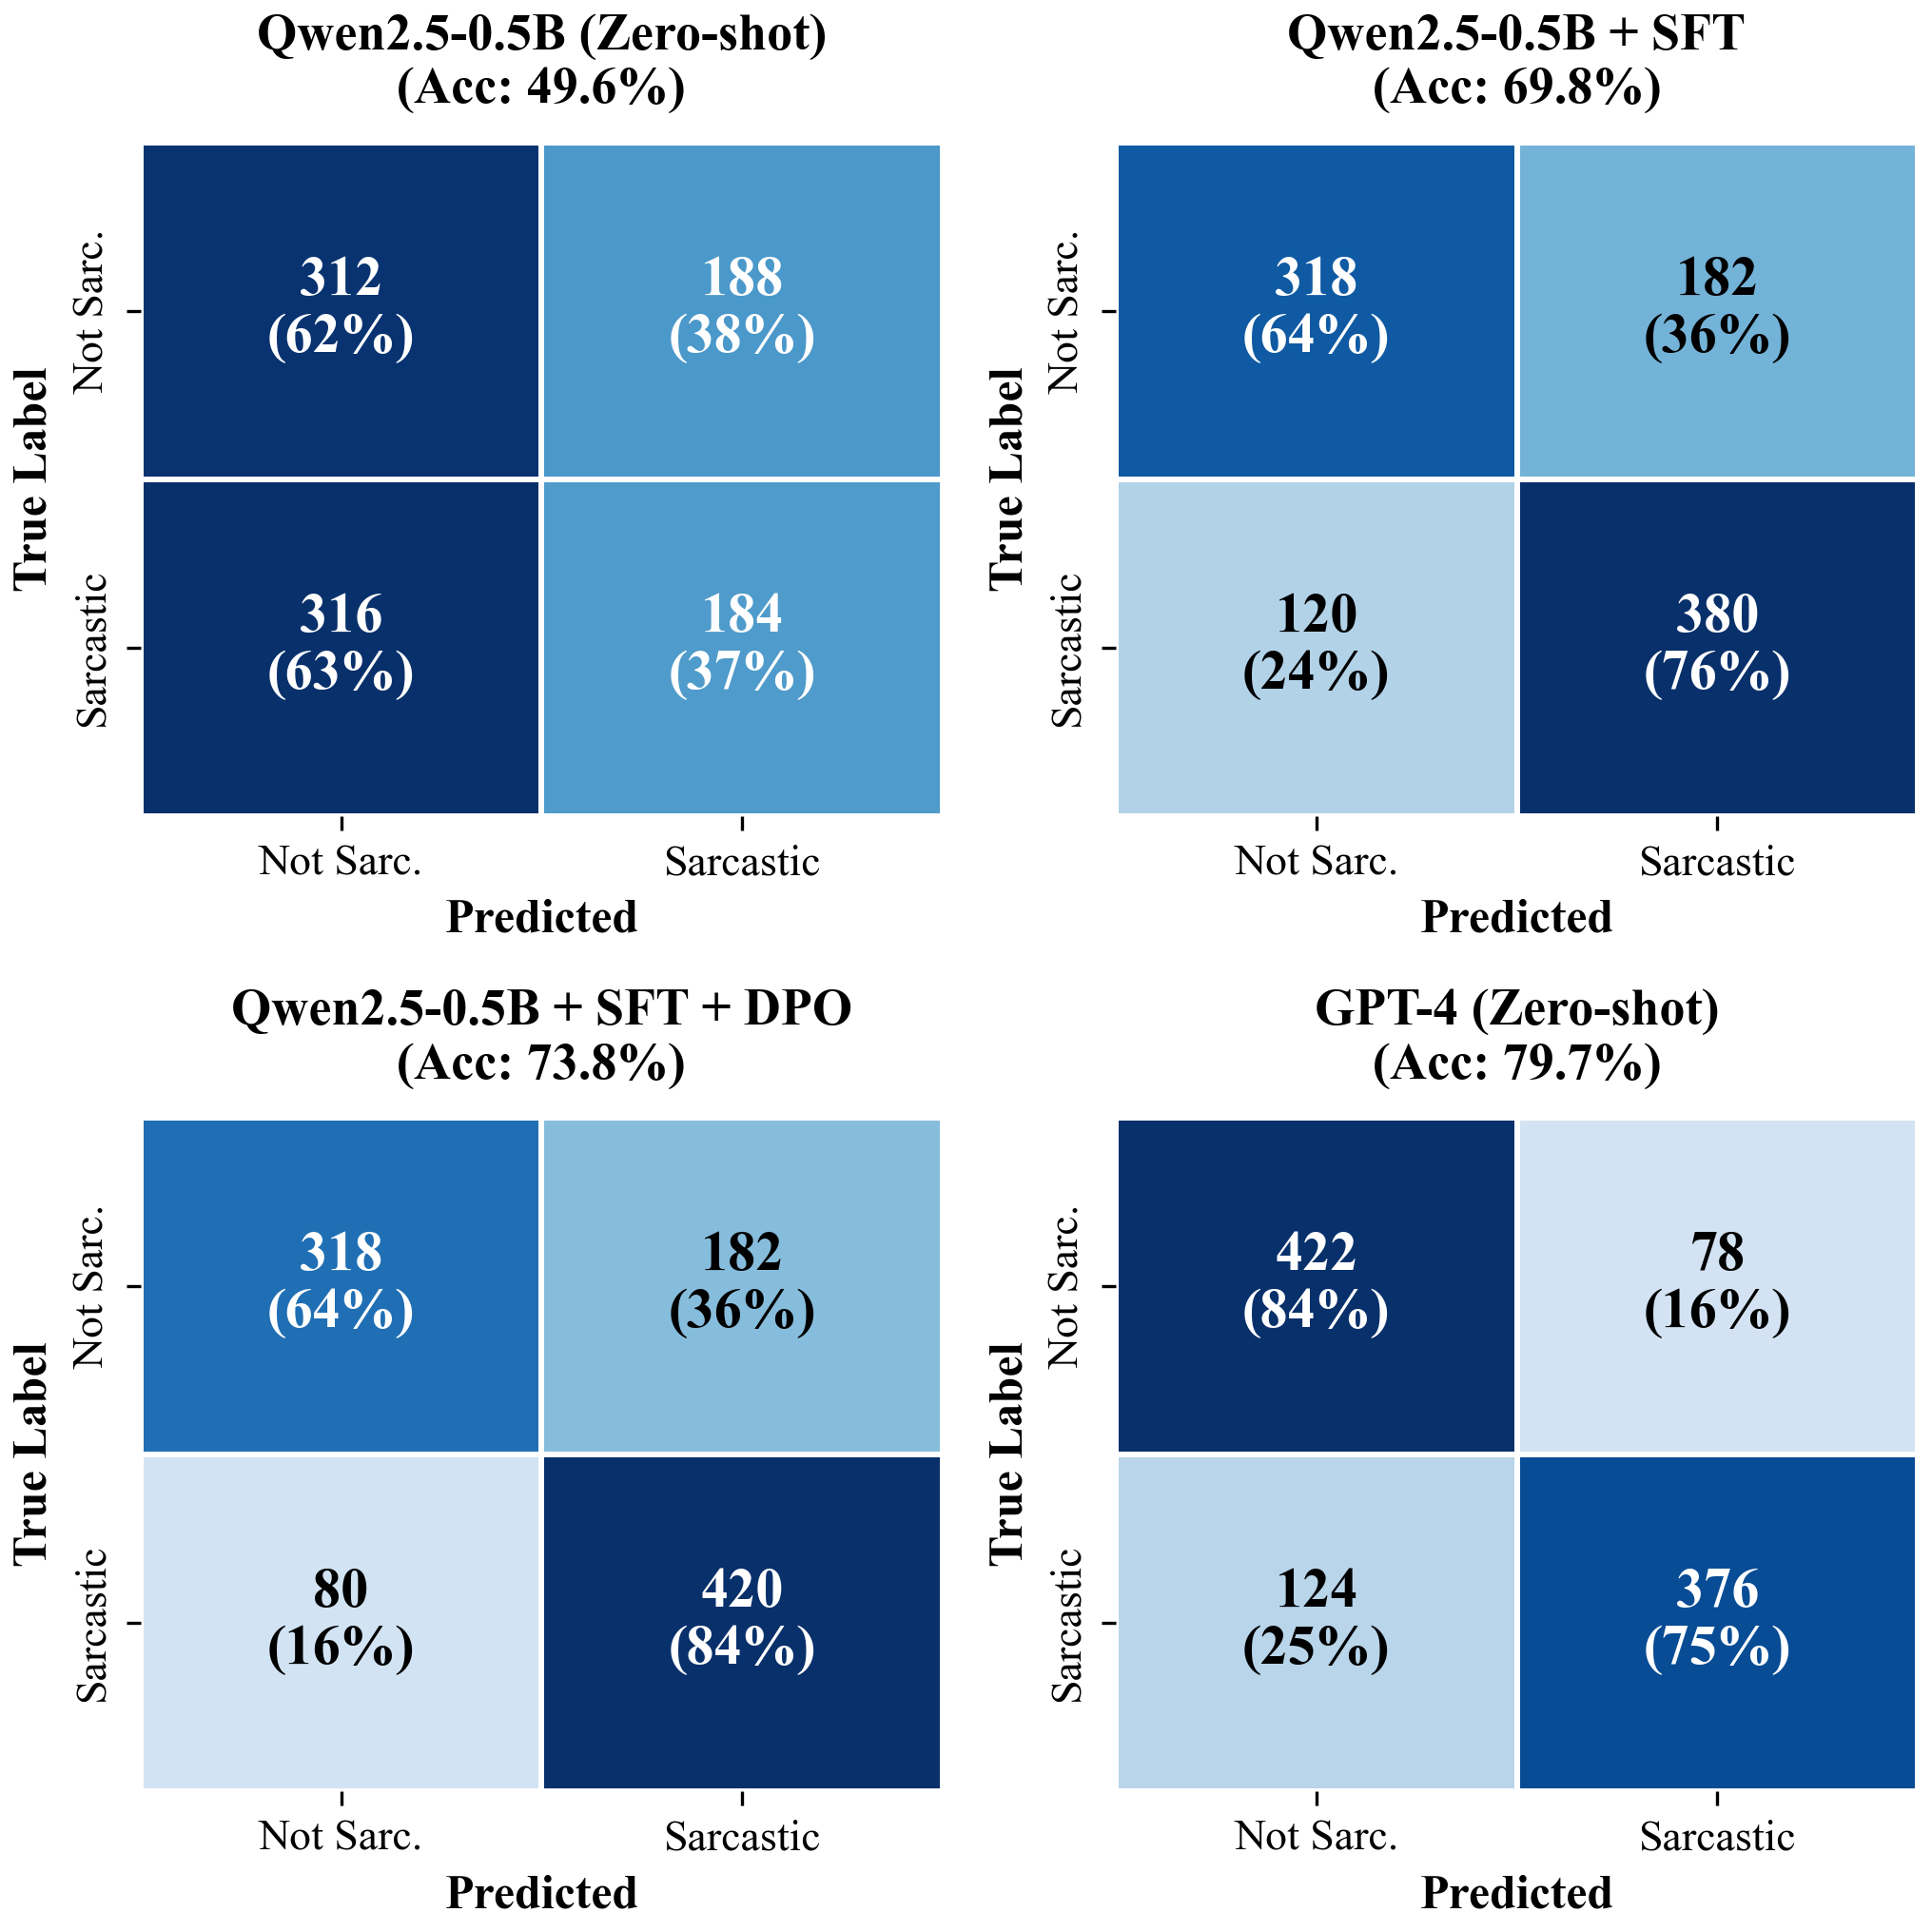

✓ Saved: fig_confusion_matrices.pdf/png


In [ ]:
if results and 'models' in results:
    models_df = pd.DataFrame(results['models'])
    
    # Define model order and clean names for 2x2 grid
    model_order = [
        'Base Model (Zero-shot)',
        'SFT Model (GEN)', 
        'DPO Model (GEN Enhanced)',
        'gpt-4 (Zero-shot)'
    ]
    
    name_mapping = {
        'Base Model (Zero-shot)': 'Qwen2.5-0.5B (Zero-shot)',
        'SFT Model (GEN)': 'Qwen2.5-0.5B (SFT)',
        'DPO Model (GEN Enhanced)': 'Qwen2.5-0.5B (SFT + DPO)',
        'gpt-4 (Zero-shot)': 'GPT-4 (Zero-shot)'
    }
    
    # Reorder models
    models_df['sort_order'] = models_df['model_name'].apply(
        lambda x: model_order.index(x) if x in model_order else 999
    )
    models_df = models_df.sort_values('sort_order').reset_index(drop=True)
    
    # Create 2x2 grid - IEEE format
    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(models_df.iterrows()):
        if idx >= 4:  # Only show 4 models
            break
            
        # Create confusion matrix 
        cm = np.array([
            [row['true_negatives'], row['false_positives']],
            [row['false_negatives'], row['true_positives']]
        ])
        
        # Normalize for better visualization (percentages unchanged)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        # Plot with both raw and percentage
        sns.heatmap(cm, annot=False, cmap='Blues', ax=axes[idx],
                   xticklabels=['Not Sarc.', 'Sarcastic'],
                   yticklabels=['Not Sarc.', 'Sarcastic'],
                   cbar=False, linewidths=1, linecolor='white',
                   vmin=0, vmax=cm.max())
        
        # Add annotations with count and percentage - larger text for IEEE
        for i in range(2):
            for j in range(2):
                text_color = 'white' if cm[i, j] > cm.max()/2 else 'black'
                axes[idx].text(j + 0.5, i + 0.5, f'{int(cm[i, j])}\n({cm_normalized[i, j]:.0f}%)',
                              ha='center', va='center', fontsize=14, color=text_color, fontweight='bold')
        
        clean_name = name_mapping.get(row['model_name'], row['model_name'])
        axes[idx].set_title(f"{clean_name}", fontsize=13, fontweight='bold', pad=10)
        
        axes[idx].set_ylabel('True Label', fontsize=12, fontweight='semibold')
        axes[idx].set_xlabel('Predicted', fontsize=12, fontweight='semibold')
        
        # Increase tick label sizes
        axes[idx].tick_params(axis='both', which='major', labelsize=11)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_confusion_matrices.pdf', format='pdf', dpi=300)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_confusion_matrices.png', dpi=300)
    plt.show()
    print("✓ Saved: fig_confusion_matrices.pdf/png")

## 5. DPO Training Metrics

In [162]:
# Load DPO training metrics if available
dpo_metrics_path = PROJECT_ROOT / 'models' / 'dpo_mistakes' / 'dpo_epoch_metrics.json'

if dpo_metrics_path.exists():
    with open(dpo_metrics_path) as f:
        dpo_metrics = json.load(f)
    
    print("DPO Training Metrics:")
    for key, value in dpo_metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print(f"DPO metrics not found at {dpo_metrics_path}")

DPO metrics not found at /Users/carloschreiber/Desktop/Uni/Quarter 1/CS229 - Machine Learning/Sarcasm/models/dpo_mistakes/dpo_epoch_metrics.json


## 6. Dataset Statistics

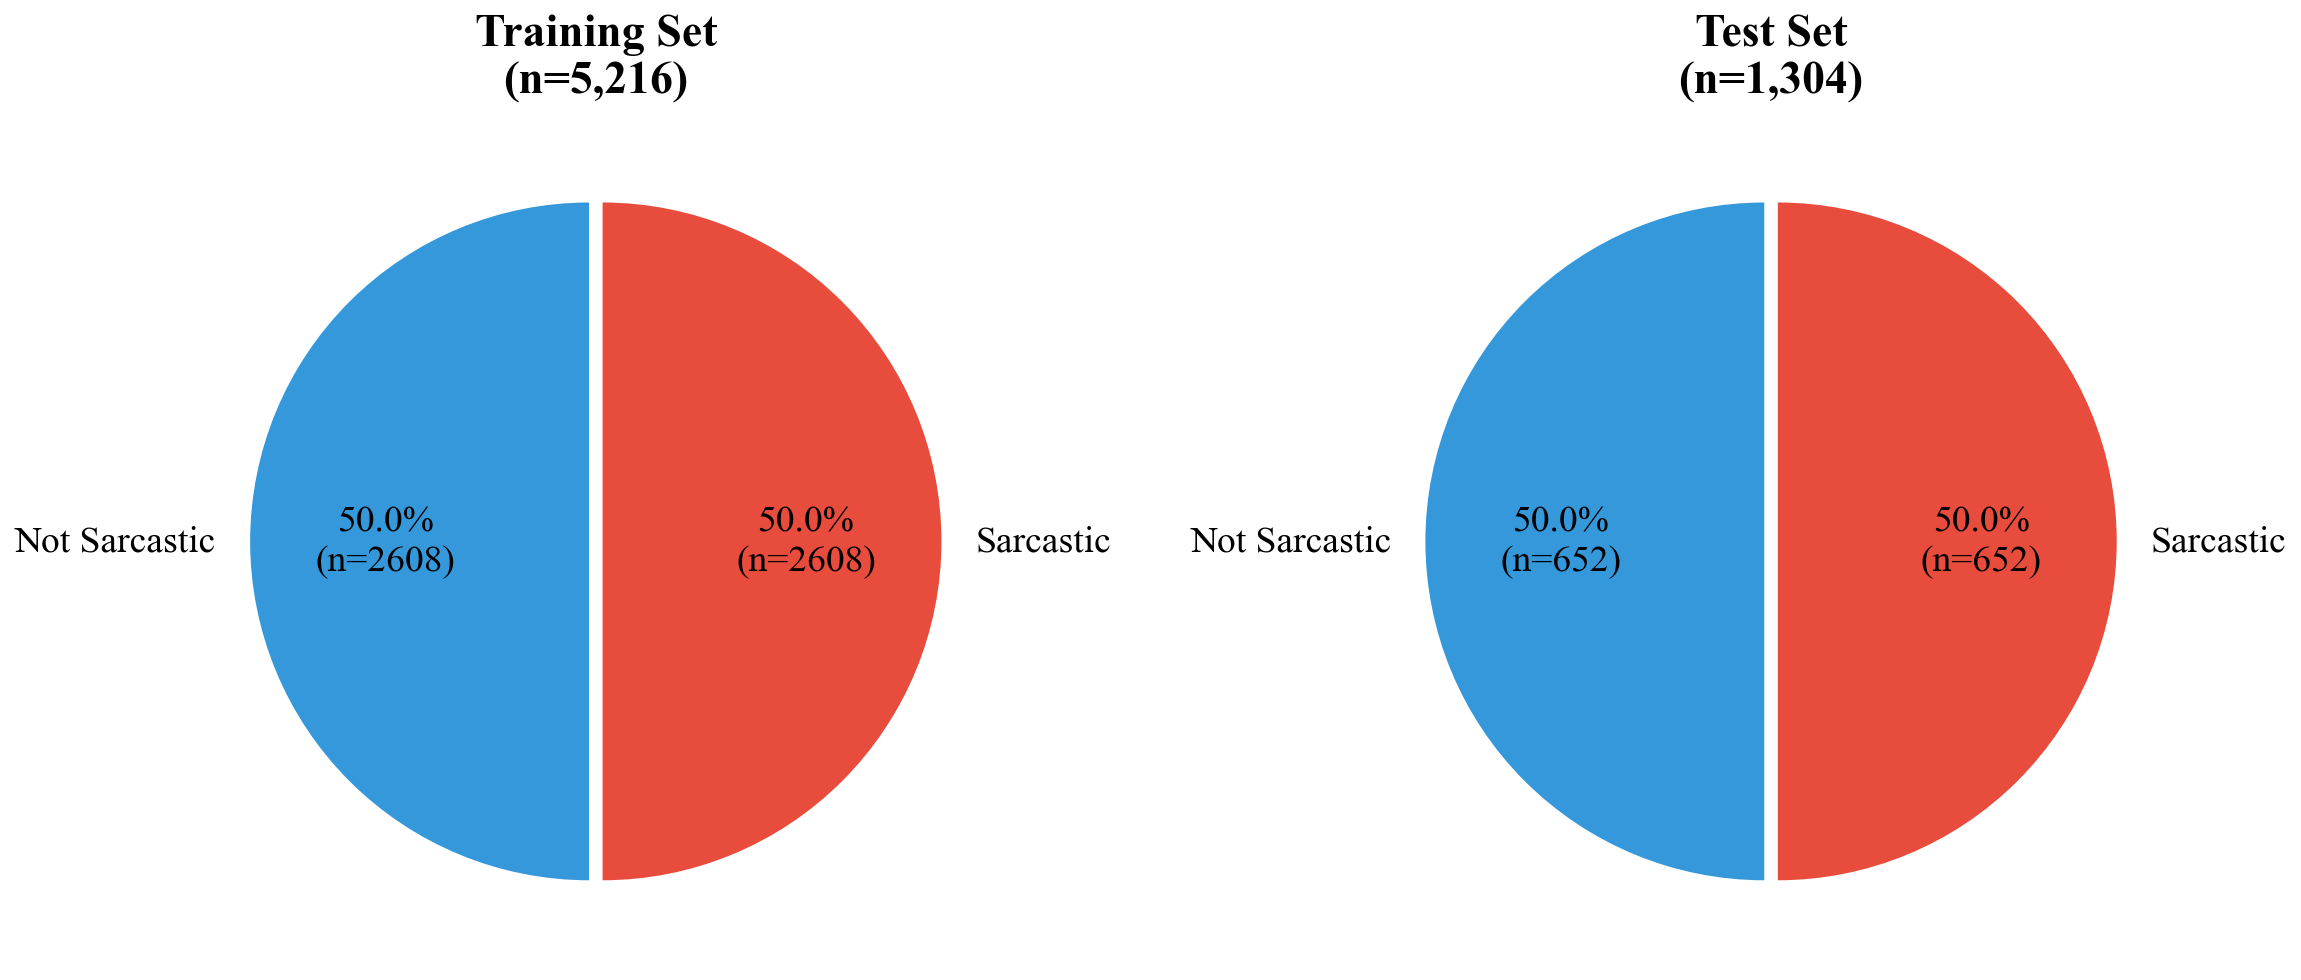

✓ Saved: fig_dataset_distribution.pdf/png

📊 Dataset Statistics:
   Training: 5,216 samples (2,608 sarc, 2,608 not)
   Test:     1,304 samples (652 sarc, 652 not)


In [163]:
# Load and display dataset statistics
train_path = PROJECT_ROOT / 'data' / 'splits' / 'gen_train.csv'
test_path = PROJECT_ROOT / 'data' / 'splits' / 'gen_test.csv'

if train_path.exists() and test_path.exists():
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    
    colors = ['#3498db', '#e74c3c']
    
    # Training set
    train_counts = train_df['class'].value_counts()
    wedges1, texts1, autotexts1 = axes[0].pie(
        train_counts, labels=['Not Sarcastic', 'Sarcastic'],
        autopct=lambda p: f'{p:.1f}%\n(n={int(p*len(train_df)/100)})',
        colors=colors, startangle=90,
        explode=(0.02, 0.02), shadow=False,
        textprops={'fontsize': 9}
    )
    axes[0].set_title(f'Training Set\n(n={len(train_df):,})', fontsize=11, fontweight='bold')
    
    # Test set
    test_counts = test_df['class'].value_counts()
    wedges2, texts2, autotexts2 = axes[1].pie(
        test_counts, labels=['Not Sarcastic', 'Sarcastic'],
        autopct=lambda p: f'{p:.1f}%\n(n={int(p*len(test_df)/100)})',
        colors=colors, startangle=90,
        explode=(0.02, 0.02), shadow=False,
        textprops={'fontsize': 9}
    )
    axes[1].set_title(f'Test Set\n(n={len(test_df):,})', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_dataset_distribution.pdf', format='pdf')
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_dataset_distribution.png', dpi=300)
    plt.show()
    print("✓ Saved: fig_dataset_distribution.pdf/png")
    
    # Print statistics
    print(f"\n📊 Dataset Statistics:")
    print(f"   Training: {len(train_df):,} samples ({train_counts['sarc']:,} sarc, {train_counts['notsarc']:,} not)")
    print(f"   Test:     {len(test_df):,} samples ({test_counts['sarc']:,} sarc, {test_counts['notsarc']:,} not)")
else:
    print("Dataset splits not found. Run 'python scripts/split_gen_dataset.py' first.")

## 7. Summary

/var/folders/wl/3406z0wj4ws1pjs8tc7l2yj80000gn/T/ipykernel_92716/1280084470.py:62: RuntimeWarning: divide by zero encountered in divide
  precision_f1 = (f1 * recall_range) / (2 * recall_range - f1)


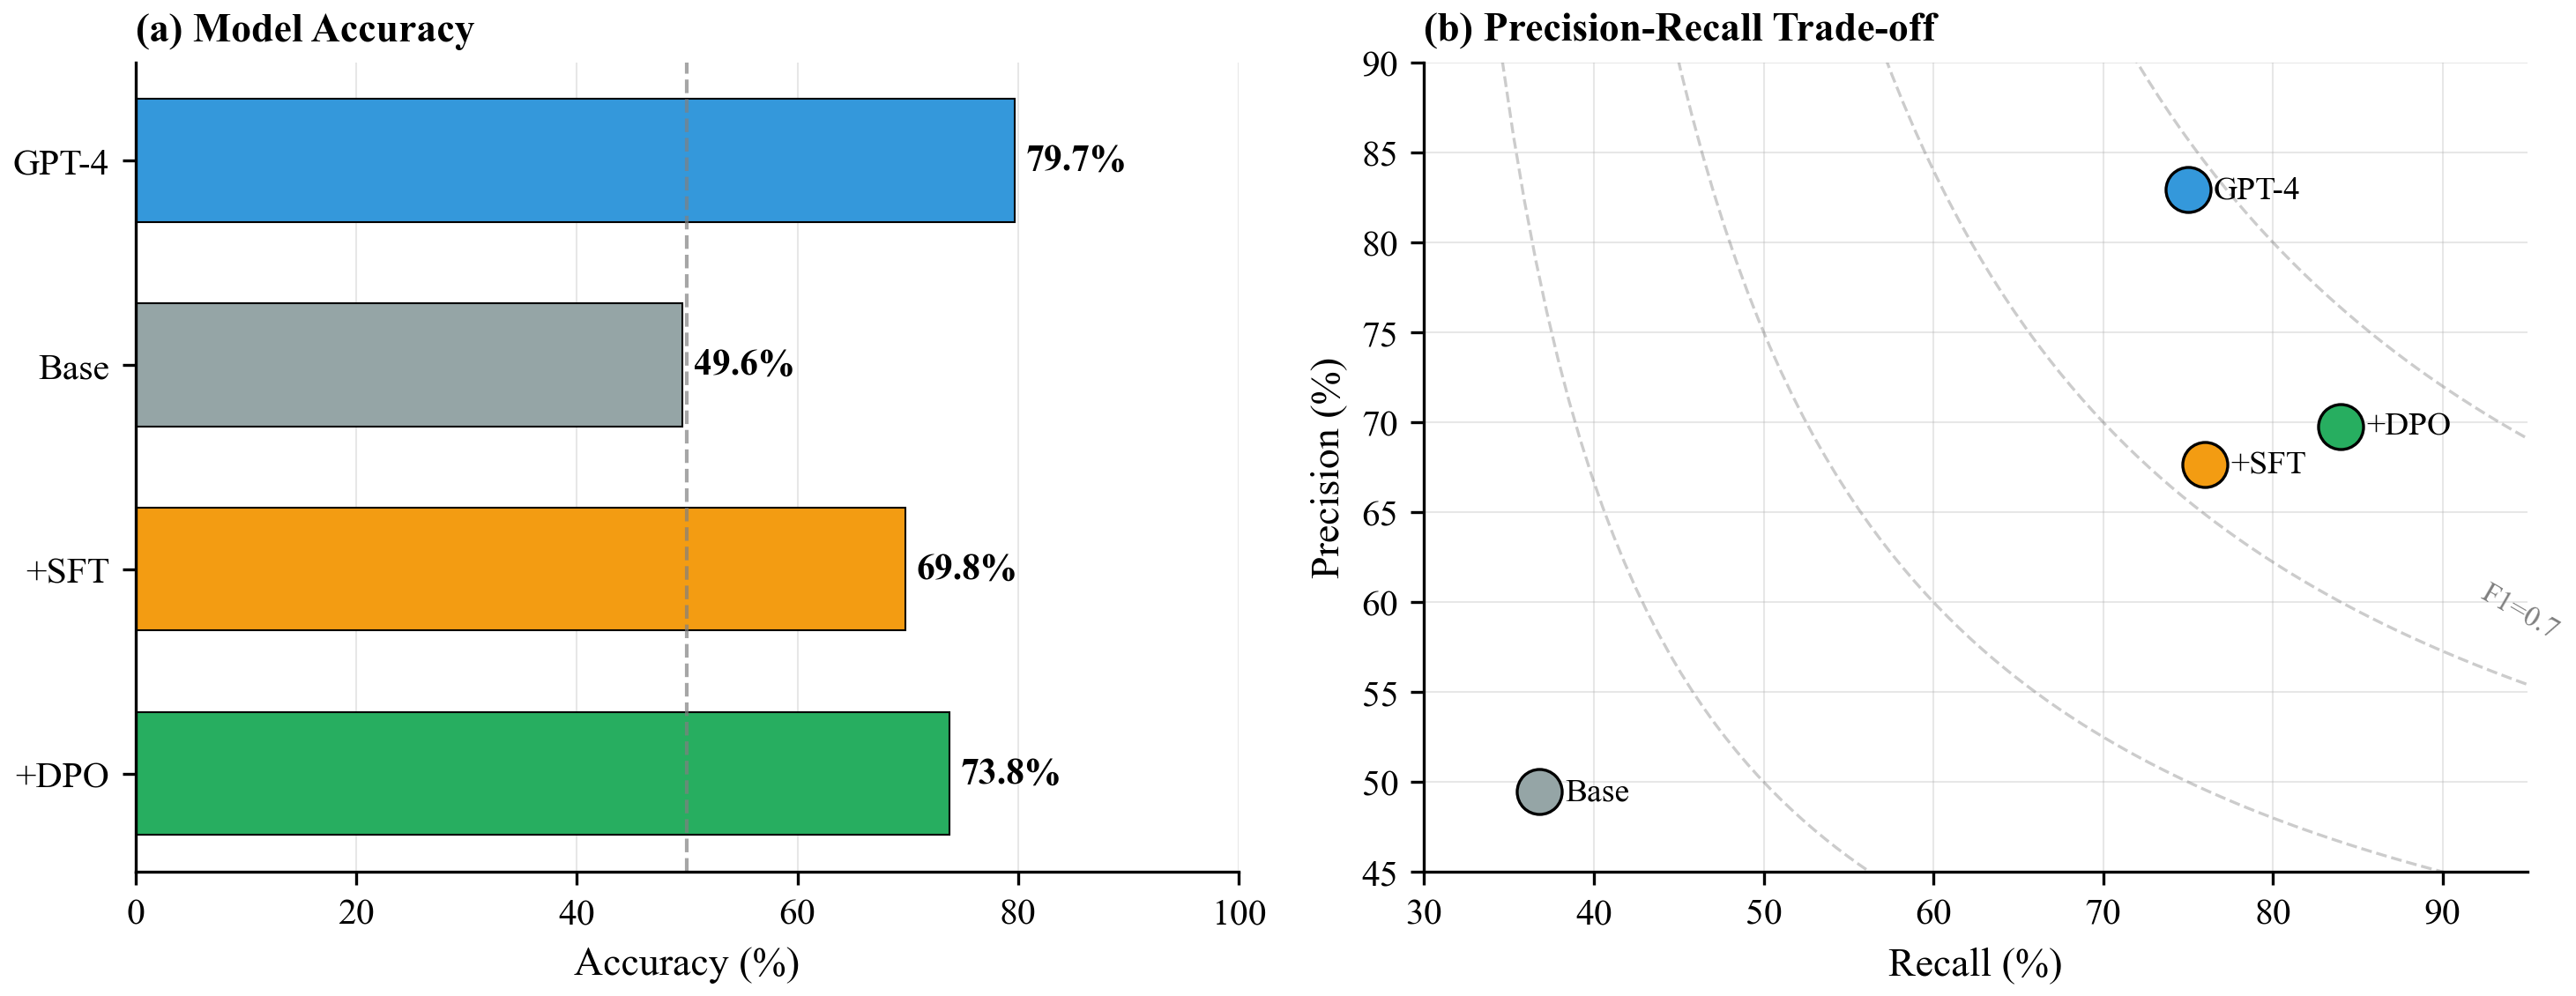

✓ Saved: fig_summary.pdf/png

📈 KEY FINDINGS

• Best overall: gpt-4 (Zero-shot) (79.7%)
• Our best model: DPO Model (GEN Enhanced) (73.8%)
• Gap to GPT-4: +5.9 percentage points
• Improvement from fine-tuning: +24.2 percentage points


In [164]:
if results and 'models' in results:
    models_df = pd.DataFrame(results['models'])
    
    # Name mapping
    name_mapping = {
        'gpt-4 (Zero-shot)': 'GPT-4',
        'Base Model (Zero-shot)': 'Base',
        'SFT Model (GEN)': '+SFT',
        'DPO Model (GEN Enhanced)': '+DPO'
    }
    models_df['clean_name'] = models_df['model_name'].map(name_mapping).fillna(models_df['model_name'])
    
    # Create comprehensive summary figure
    fig = plt.figure(figsize=(10, 4))
    
    # Left: Accuracy comparison as horizontal bar chart
    ax1 = fig.add_subplot(121)
    
    y_pos = np.arange(len(models_df))
    colors = ['#3498db', '#95a5a6', '#f39c12', '#27ae60']
    
    bars = ax1.barh(y_pos, models_df['accuracy'] * 100, 
                    color=colors[:len(models_df)], 
                    edgecolor='black', linewidth=0.5, height=0.6)
    
    # Add value labels
    for bar, acc in zip(bars, models_df['accuracy'] * 100):
        ax1.text(acc + 1, bar.get_y() + bar.get_height()/2, 
                f'{acc:.1f}%', va='center', fontsize=10, fontweight='bold')
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(models_df['clean_name'])
    ax1.set_xlabel('Accuracy (%)')
    ax1.set_xlim(0, 100)
    ax1.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax1.invert_yaxis()  # Top to bottom
    ax1.xaxis.grid(True, linestyle='-', alpha=0.3)
    ax1.set_axisbelow(True)
    ax1.set_title('(a) Model Accuracy', fontsize=11, fontweight='bold', loc='left')
    
    # Right: Precision vs Recall scatter
    ax2 = fig.add_subplot(122)
    
    for idx, (_, row) in enumerate(models_df.iterrows()):
        ax2.scatter(row['recall'] * 100, row['precision'] * 100, 
                   s=150, c=colors[idx], edgecolor='black', linewidth=0.8, zorder=3)
        ax2.annotate(row['clean_name'], 
                    (row['recall'] * 100 + 1.5, row['precision'] * 100),
                    fontsize=9, va='center')
    
    ax2.set_xlabel('Recall (%)')
    ax2.set_ylabel('Precision (%)')
    ax2.set_xlim(30, 95)
    ax2.set_ylim(45, 90)
    ax2.grid(True, linestyle='-', alpha=0.3)
    ax2.set_axisbelow(True)
    ax2.set_title('(b) Precision-Recall Trade-off', fontsize=11, fontweight='bold', loc='left')
    
    # Add F1 iso-lines
    for f1 in [0.5, 0.6, 0.7, 0.8]:
        recall_range = np.linspace(0.3, 0.95, 100)
        precision_f1 = (f1 * recall_range) / (2 * recall_range - f1)
        valid = (precision_f1 > 0) & (precision_f1 <= 1)
        ax2.plot(recall_range[valid] * 100, precision_f1[valid] * 100, 
                '--', color='gray', alpha=0.4, linewidth=0.8)
        # Label F1 curves
        if f1 == 0.7:
            ax2.text(92, 58, f'F1={f1}', fontsize=8, color='gray', rotation=-30)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_summary.pdf', format='pdf')
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_summary.png', dpi=300)
    plt.show()
    print("✓ Saved: fig_summary.pdf/png")
    
    # Print final summary
    print("\n" + "="*60)
    print("📈 KEY FINDINGS")
    print("="*60)
    
    best_idx = models_df['accuracy'].idxmax()
    best = models_df.loc[best_idx]
    
    # Get our best model (excluding GPT-4)
    our_models = models_df[~models_df['model_name'].str.contains('gpt', case=False)]
    our_best_idx = our_models['accuracy'].idxmax()
    our_best = our_models.loc[our_best_idx]
    
    gpt4 = models_df[models_df['model_name'].str.contains('gpt', case=False)].iloc[0] if len(models_df[models_df['model_name'].str.contains('gpt', case=False)]) > 0 else None
    
    print(f"\n• Best overall: {best['model_name']} ({best['accuracy']:.1%})")
    print(f"• Our best model: {our_best['model_name']} ({our_best['accuracy']:.1%})")
    
    if gpt4 is not None:
        gap = (gpt4['accuracy'] - our_best['accuracy']) * 100
        print(f"• Gap to GPT-4: {gap:+.1f} percentage points")
    
    base = models_df[models_df['model_name'].str.contains('Base', case=False)].iloc[0]
    improvement = (our_best['accuracy'] - base['accuracy']) * 100
    print(f"• Improvement from fine-tuning: +{improvement:.1f} percentage points")
    print("="*60)

## Inference Latency Comparison

Comparing the inference latency (ms per sample) across different model stages.

In [165]:
# Load latency results
latency_path = '../results/latency_results.json'
with open(latency_path, 'r') as f:
    latency_data = json.load(f)

print("Latency Results Loaded")
print(f"Timestamp: {latency_data['timestamp']}")
print(f"Config: {latency_data['config']}")

# Extract data
latency_results = latency_data['results']

# Prepare data for plotting
models = []
means = []
stds = []
labels = []

model_display_names = {
    'base_qwen': 'Base Qwen\n(Zero-shot)',
    'sft': 'SFT\n(Fine-tuned)',
    'dpo': 'DPO\n(Aligned)',
    'gpt4': 'GPT-4\n(API)'
}

for model_key in ['base_qwen', 'sft', 'dpo', 'gpt4']:
    if model_key in latency_results:
        models.append(model_key)
        means.append(latency_results[model_key]['mean'])
        stds.append(latency_results[model_key]['std'])
        labels.append(model_display_names.get(model_key, model_key))

print(f"\nLatency Summary (ms per sample):")
for model, mean, std in zip(labels, means, stds):
    print(f"  {model.replace(chr(10), ' ')}: {mean:.1f} ± {std:.1f} ms")

Latency Results Loaded
Timestamp: 2025-12-01T18:07:53.752172
Config: {'num_runs': 10, 'warmup_runs': 3, 'num_texts': 5, 'gpt4_model': 'gpt-4'}

Latency Summary (ms per sample):
  Base Qwen (Zero-shot): 140.0 ± 7.4 ms
  SFT (Fine-tuned): 170.6 ± 11.9 ms
  DPO (Aligned): 165.0 ± 2.2 ms
  GPT-4 (API): 631.4 ± 261.5 ms


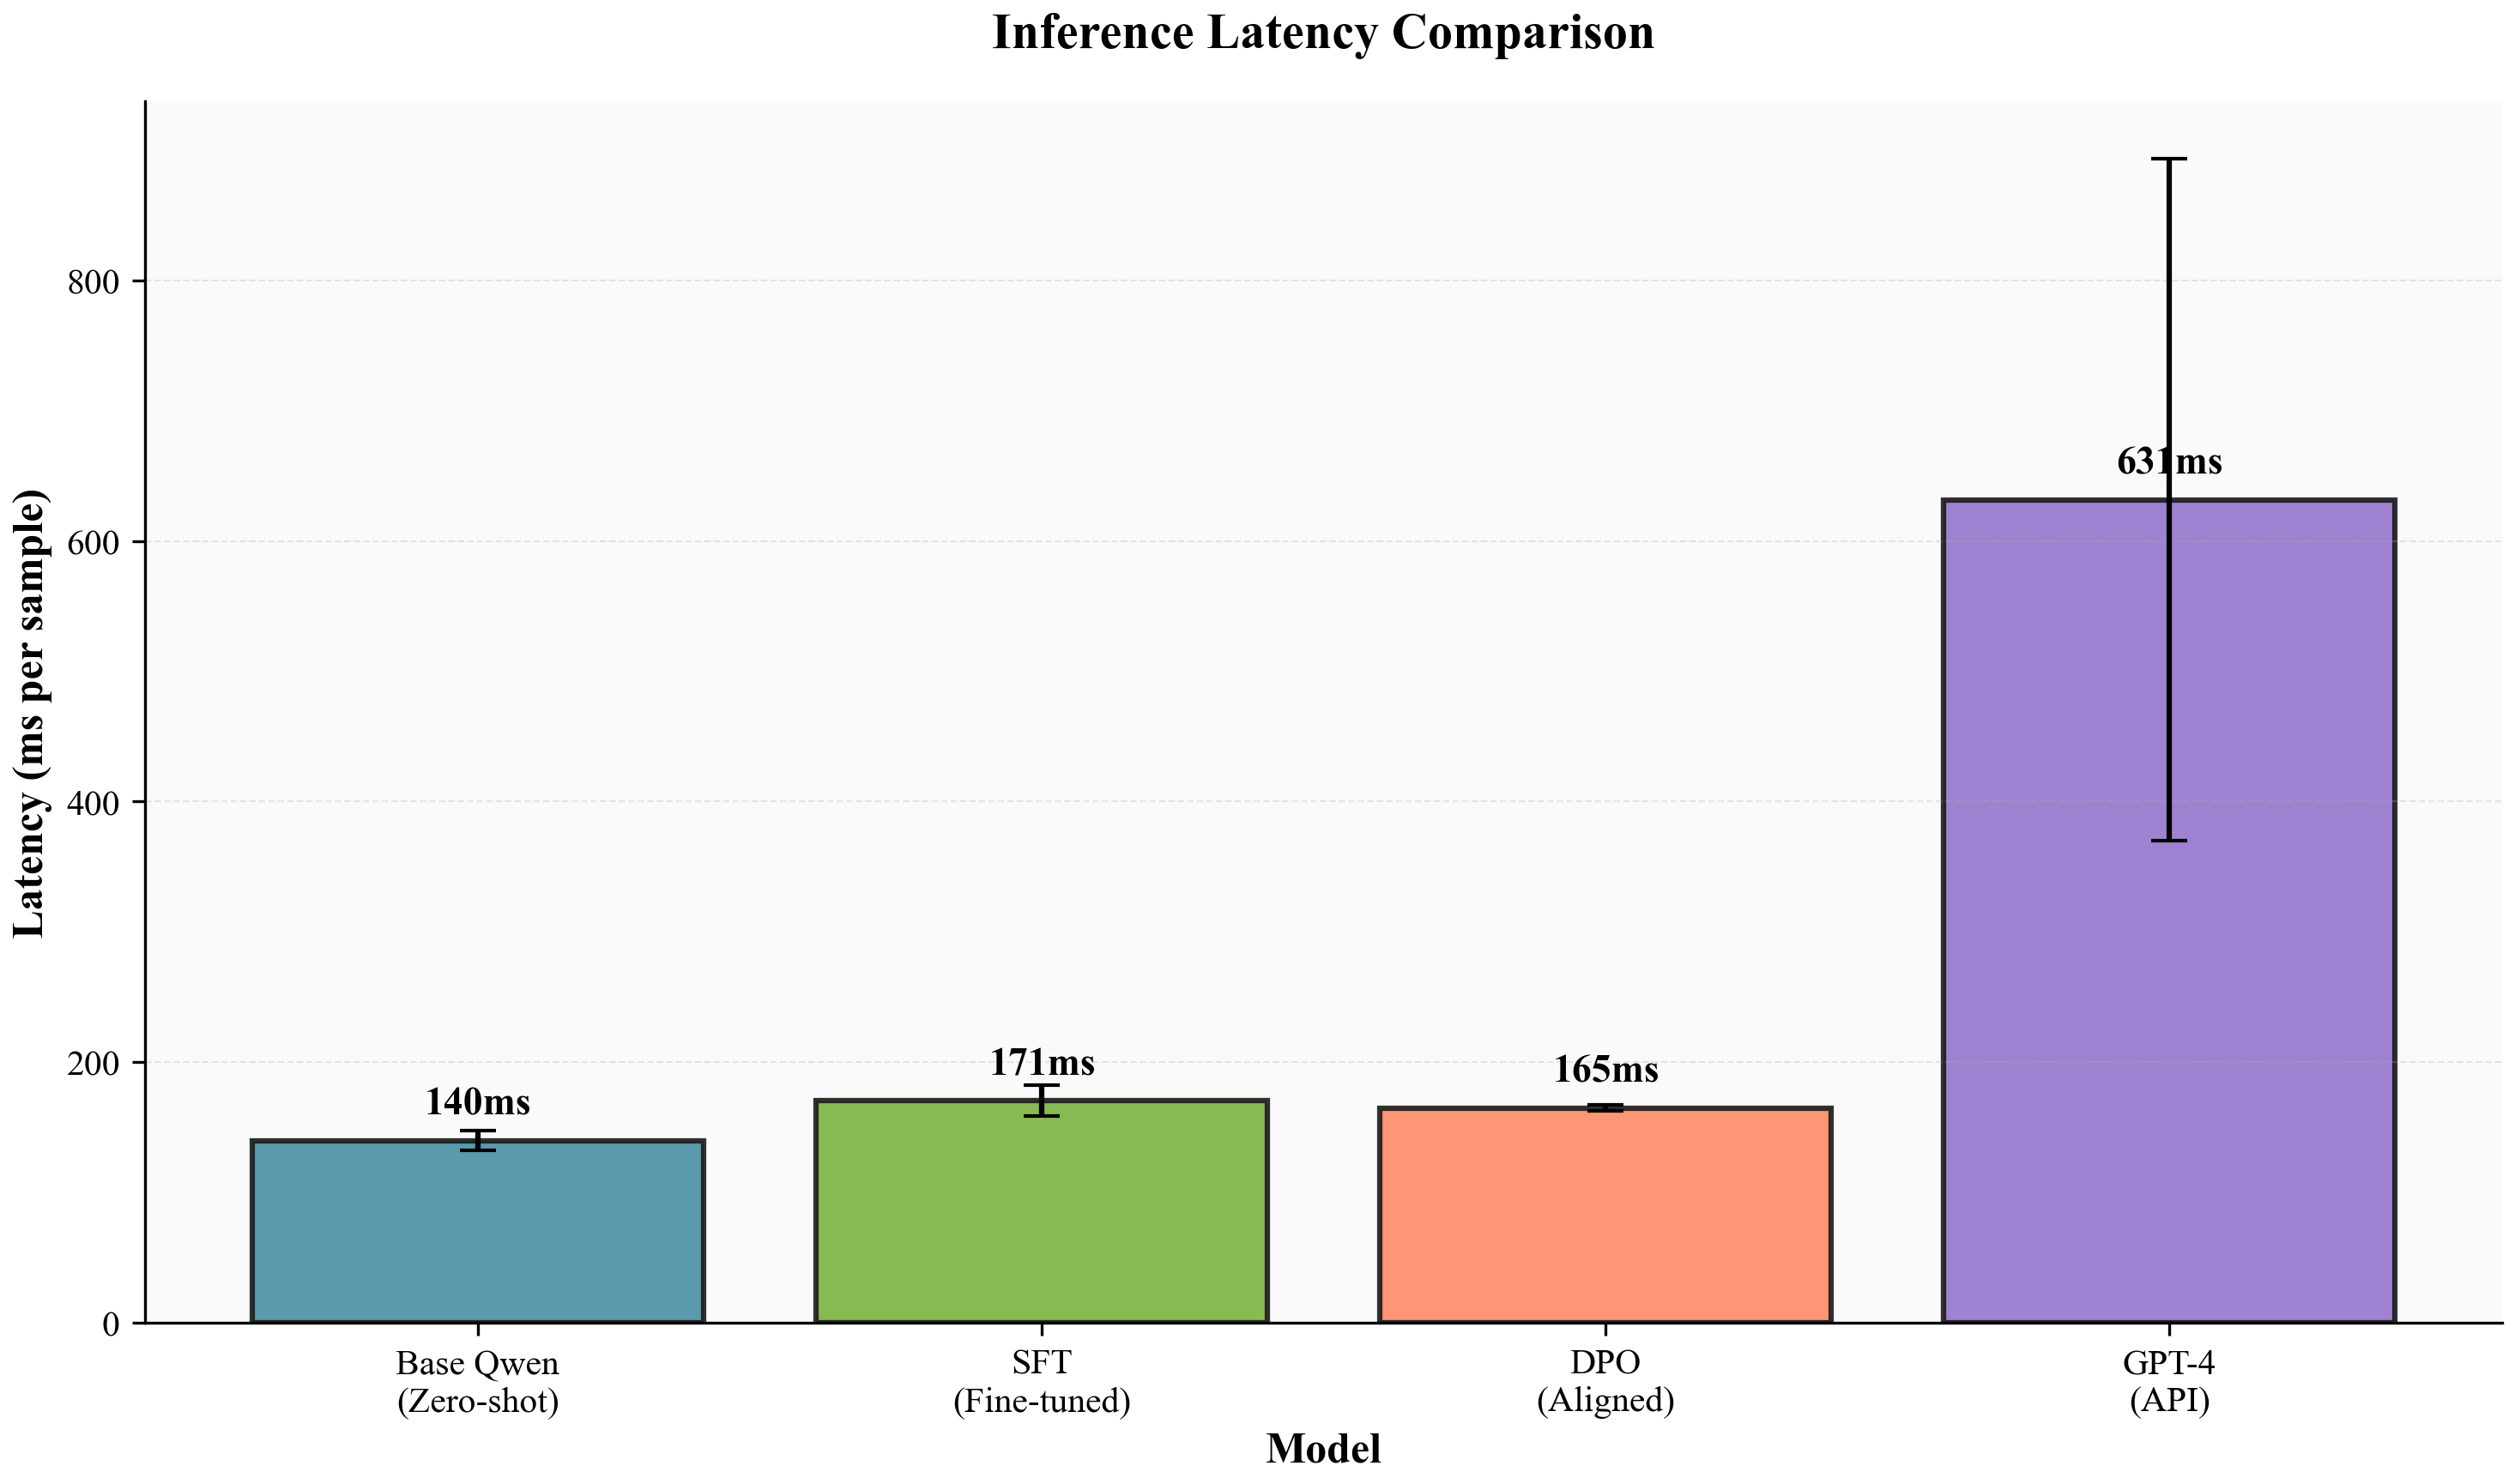


✓ Saved: latency_comparison.png


In [166]:
# Create latency bar chart with error bars
fig, ax = plt.subplots(figsize=(10, 6))

# Colors matching the paper style
colors = ['#4A90A4', '#7CB342', '#FF8A65', '#9575CD']

x_pos = np.arange(len(models))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors[:len(models)], 
              edgecolor='#1a1a1a', linewidth=1.5, alpha=0.9)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax.annotate(f'{mean:.0f}ms',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

ax.set_ylabel('Latency (ms per sample)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Inference Latency Comparison', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add a subtle background
ax.set_facecolor('#fafafa')

plt.tight_layout()
plt.savefig('latency_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved: latency_comparison.png")

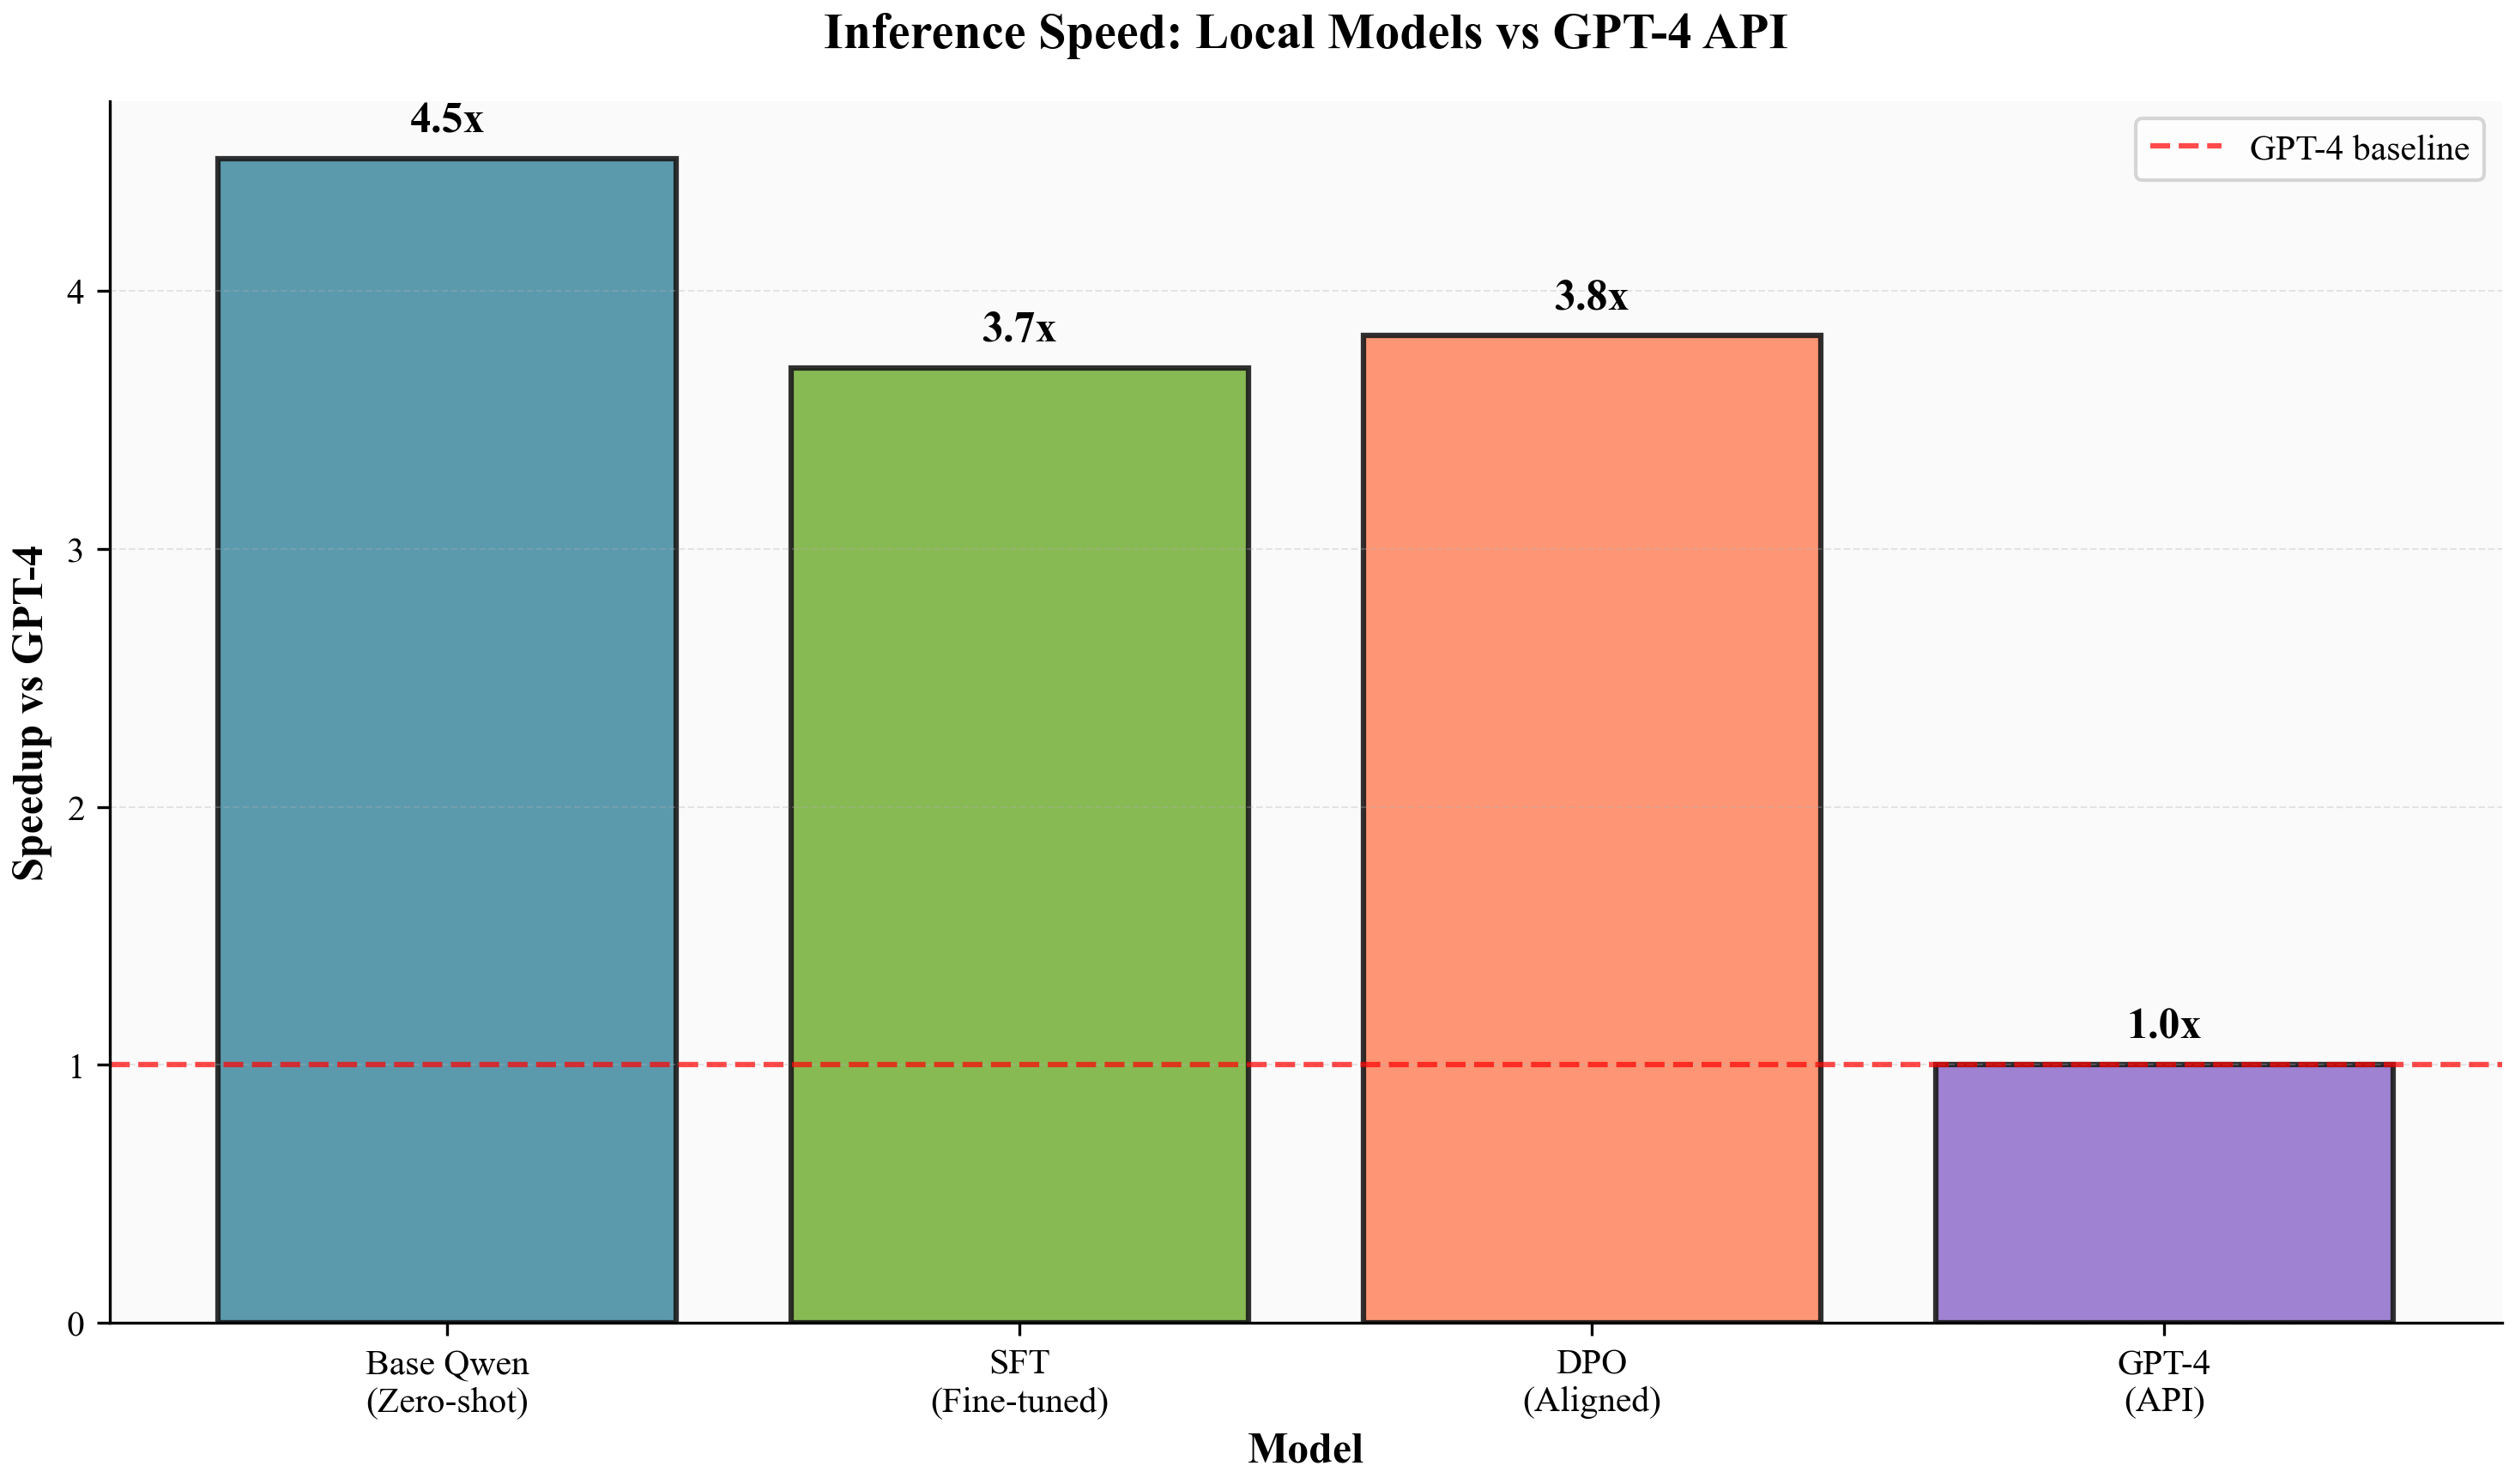


✓ Saved: latency_speedup.png

Key Insight: Local models are 4.5-3.8x faster than GPT-4 API!


In [167]:
# Create speedup comparison chart (relative to GPT-4)
fig, ax = plt.subplots(figsize=(10, 6))

gpt4_latency = latency_results['gpt4']['mean']
speedups = [gpt4_latency / m for m in means]

bars = ax.bar(x_pos, speedups, color=colors[:len(models)], 
              edgecolor='#1a1a1a', linewidth=1.5, alpha=0.9)

# Add value labels
for bar, speedup in zip(bars, speedups):
    height = bar.get_height()
    ax.annotate(f'{speedup:.1f}x',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add reference line at 1x
ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='GPT-4 baseline')

ax.set_ylabel('Speedup vs GPT-4', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Inference Speed: Local Models vs GPT-4 API', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper right')
ax.set_facecolor('#fafafa')

plt.tight_layout()
plt.savefig('latency_speedup.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved: latency_speedup.png")
print(f"\nKey Insight: Local models are {speedups[0]:.1f}-{speedups[2]:.1f}x faster than GPT-4 API!")

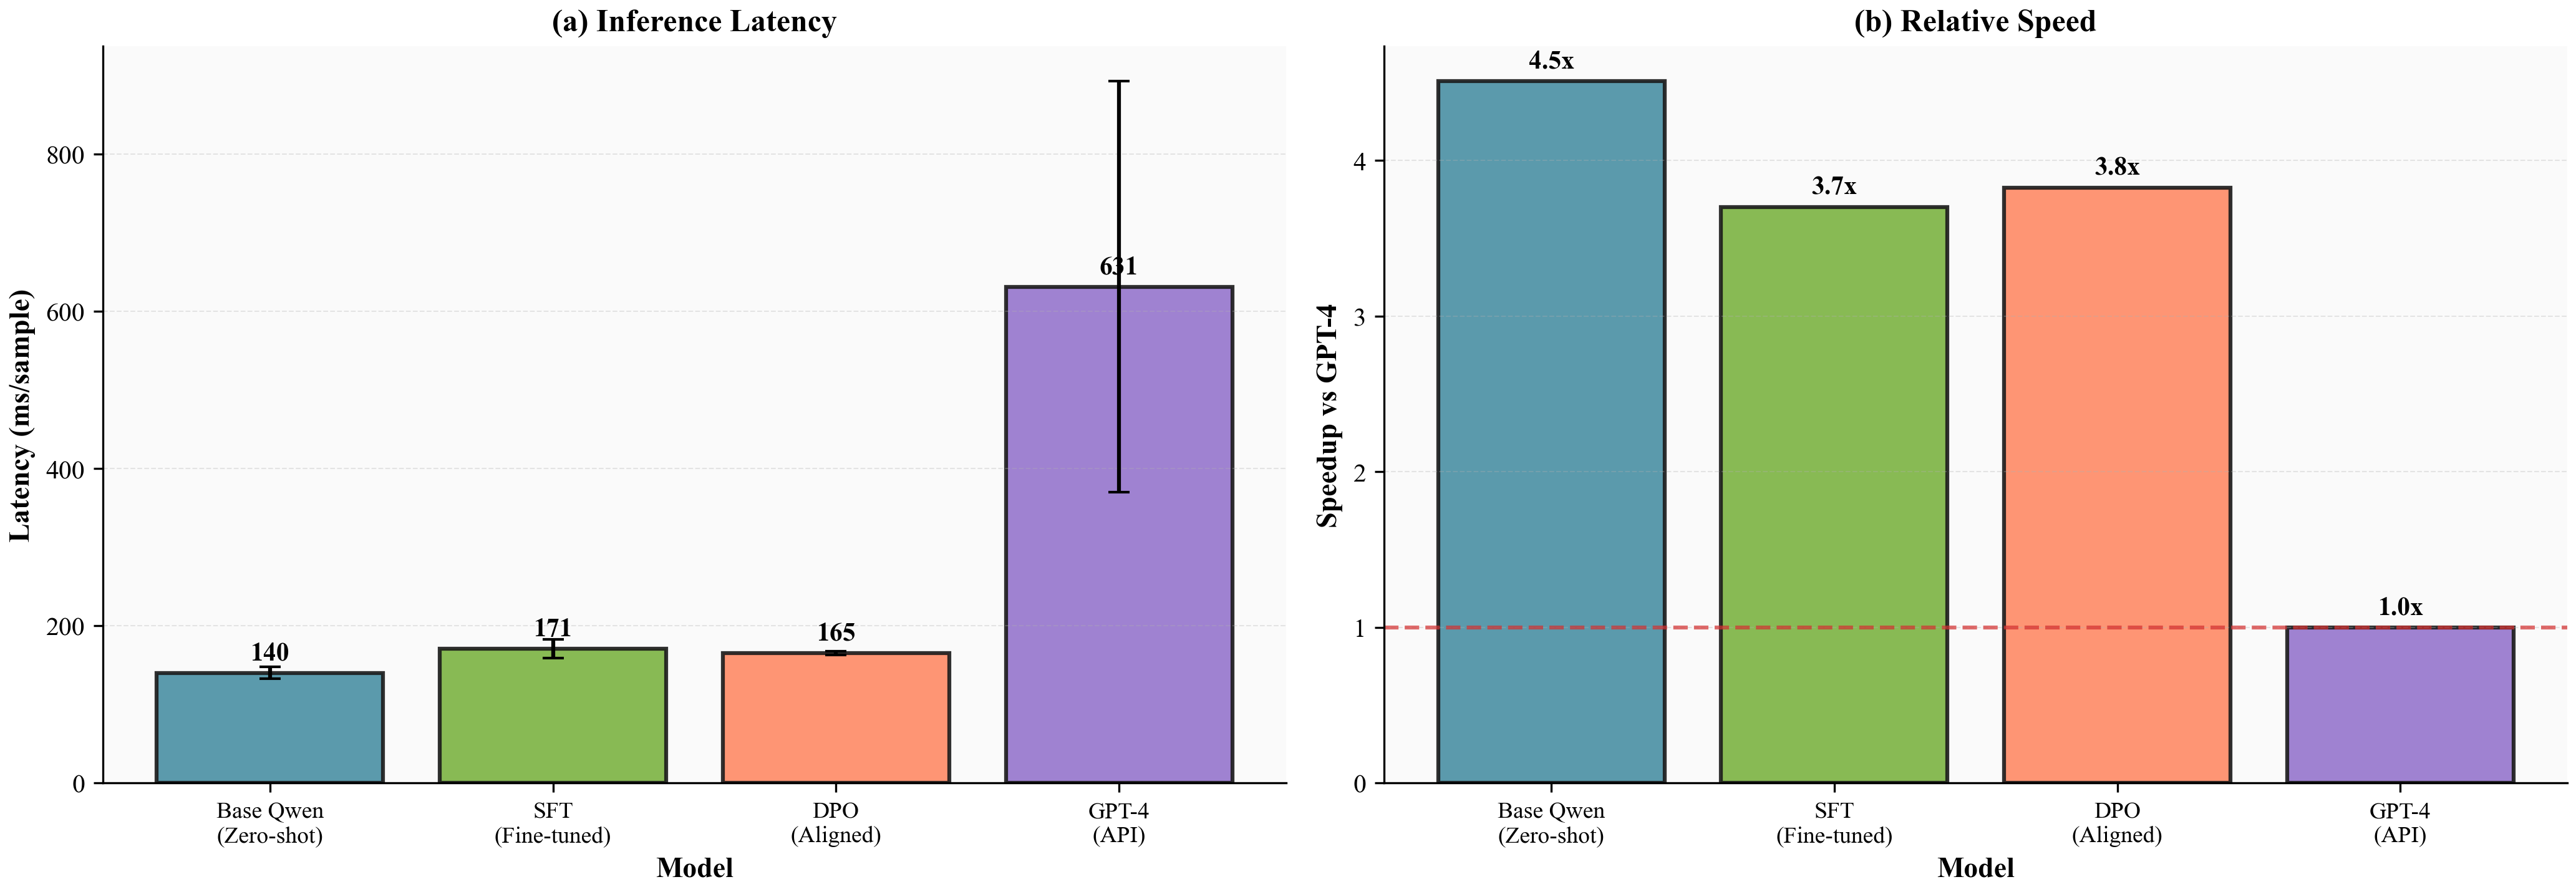


✓ Saved: latency_combined_figure.png (paper-ready)

LATENCY SUMMARY TABLE
Model                Latency (ms)    Speedup   
------------------------------------------------------------
Base Qwen (Zero-shot)  140.0 ± 7.4       4.5x
SFT (Fine-tuned)      170.6 ± 11.9      3.7x
DPO (Aligned)         165.0 ± 2.2       3.8x
GPT-4 (API)           631.4 ± 261.5     1.0x


In [168]:
# Create combined latency + accuracy chart (paper figure)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Latency bar chart
bars1 = ax1.bar(x_pos, means, yerr=stds, capsize=4, color=colors[:len(models)], 
                edgecolor='#1a1a1a', linewidth=1.5, alpha=0.9)

for bar, mean in zip(bars1, means):
    height = bar.get_height()
    ax1.annotate(f'{mean:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

ax1.set_ylabel('Latency (ms/sample)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_title('(a) Inference Latency', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(labels, fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_facecolor('#fafafa')

# Right: Speedup chart
bars2 = ax2.bar(x_pos, speedups, color=colors[:len(models)], 
                edgecolor='#1a1a1a', linewidth=1.5, alpha=0.9)

for bar, speedup in zip(bars2, speedups):
    height = bar.get_height()
    ax2.annotate(f'{speedup:.1f}x',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

ax2.axhline(y=1, color='#d32f2f', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_ylabel('Speedup vs GPT-4', fontsize=11, fontweight='bold')
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_title('(b) Relative Speed', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(labels, fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_facecolor('#fafafa')

plt.tight_layout()
plt.savefig('latency_combined_figure.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved: latency_combined_figure.png (paper-ready)")

# Print summary table
print("\n" + "="*60)
print("LATENCY SUMMARY TABLE")
print("="*60)
print(f"{'Model':<20} {'Latency (ms)':<15} {'Speedup':<10}")
print("-"*60)
for label, mean, std, speedup in zip(labels, means, stds, speedups):
    clean_label = label.replace('\n', ' ')
    print(f"{clean_label:<20} {mean:>6.1f} ± {std:<6.1f} {speedup:>6.1f}x")
print("="*60)

## Efficiency Frontier: Latency vs F1 Score

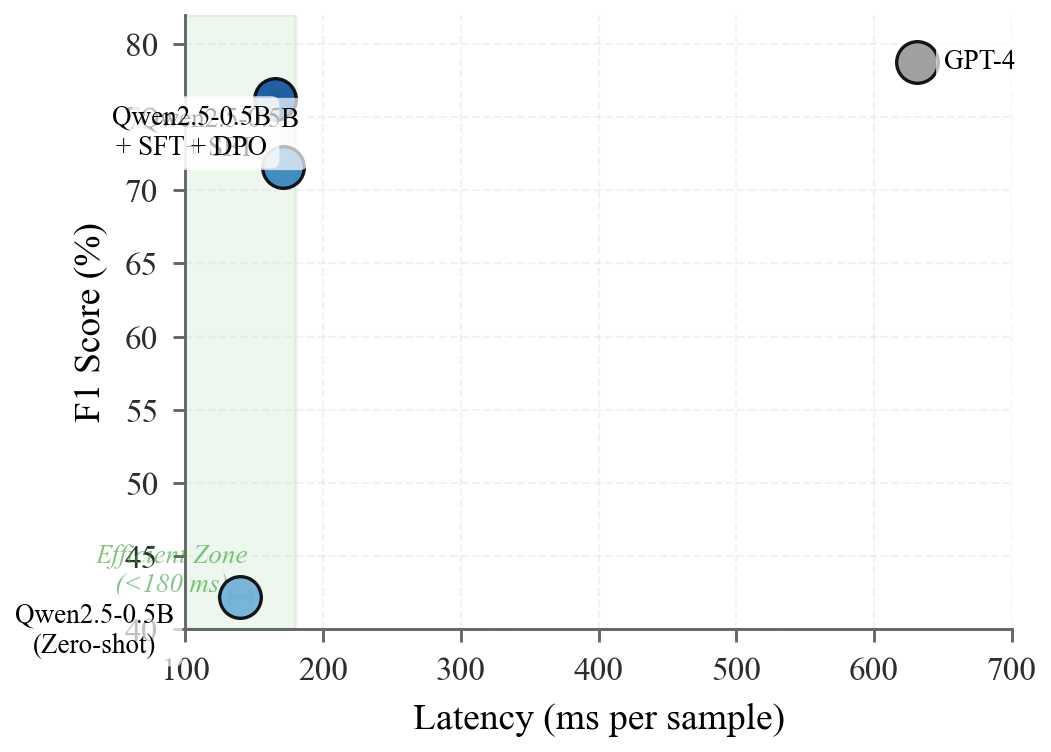

✓ Saved: fig_efficiency_frontier.pdf/png

📊 Efficiency Frontier Analysis:
  Qwen variants: 42.2–76.2% F1
  Qwen latency: <171 ms
  GPT-4: 78.8% F1 at 631 ms
  GPT-4 latency: 3.7× slower than Qwen variants
  F1 gap: 2.5 percentage points


In [169]:
# Efficiency Frontier: Latency vs F1 Score
# Qwen variants achieve 70–76% F1 with <170 ms latency, 
# while GPT-4 requires 3–4× longer inference despite only marginal F1 gains (78.8% vs 76.2%)

if results and 'models' in results and latency_results:
    # Prepare data: match models to their latency and F1 scores
    model_data = []
    
    # Map latency keys to model names
    latency_model_map = {
        'base_qwen': 'Base Model (Zero-shot)',
        'sft': 'SFT Model (GEN)',
        'dpo': 'DPO Model (GEN Enhanced)',
        'gpt4': 'gpt-4 (Zero-shot)'
    }
    
    # Clean display names
    display_name_map = {
        'Base Model (Zero-shot)': 'Qwen2.5-0.5B\n(Zero-shot)',
        'SFT Model (GEN)': 'Qwen2.5-0.5B\n+ SFT',
        'DPO Model (GEN Enhanced)': 'Qwen2.5-0.5B\n+ SFT + DPO',
        'gpt-4 (Zero-shot)': 'GPT-4'
    }
    
    models_df_frontier = pd.DataFrame(results['models'])
    
    for latency_key, model_name in latency_model_map.items():
        model_row = models_df_frontier[models_df_frontier['model_name'] == model_name]
        if not model_row.empty and latency_key in latency_results:
            model_data.append({
                'name': display_name_map.get(model_name, model_name),
                'latency': latency_results[latency_key]['mean'],
                'latency_std': latency_results[latency_key]['std'],
                'f1': model_row['f1_score'].values[0] * 100,
                'is_gpt4': latency_key == 'gpt4'
            })
    
    # Create efficiency frontier plot - IEEE format
    fig_efficiency, ax = plt.subplots(figsize=(3.5, 2.5))
    
    # Plot points
    # Color scheme matching model comparison: blues for Qwen variants, gray for GPT-4
    color_map = {
        'Qwen2.5-0.5B\n(Zero-shot)': '#6baed6',
        'Qwen2.5-0.5B\n+ SFT': '#3182bd',
        'Qwen2.5-0.5B\n+ SFT + DPO': '#08519c',
        'GPT-4': '#969696'
    }
    
    for data in model_data:
        ax.scatter(data['latency'], data['f1'], s=100,
                  color=color_map.get(data['name'], '#000000'), 
                  marker='o', edgecolor='black', linewidth=0.8, 
                  zorder=5, alpha=0.9)
        if not data['is_gpt4']:
            # Error bars for latency uncertainty (only for Qwen variants)
            ax.errorbar(data['latency'], data['f1'], 
                       xerr=data['latency_std'],
                       fmt='none', ecolor='#666666', alpha=0.3, 
                       capsize=2, linewidth=1, zorder=3)
    
    # Add labels for each point (slightly offset to avoid overlap)
    label_offsets = {
        'Qwen2.5-0.5B\n(Zero-shot)': (-35, -8),
        'Qwen2.5-0.5B\n+ SFT': (-15, 8),
        'Qwen2.5-0.5B\n+ SFT + DPO': (-20, -8),
        'GPT-4': (15, 0)
    }
    
    for data in model_data:
        offset = label_offsets.get(data['name'], (10, 0))
        ax.annotate(data['name'], 
                   xy=(data['latency'], data['f1']),
                   xytext=offset,
                   textcoords='offset points',
                   fontsize=6.5, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor='white', edgecolor='none', alpha=0.7),
                   zorder=6)
    
    # Add efficiency zone highlighting (optional - shows where Qwen models cluster)
    ax.axvspan(0, 180, alpha=0.08, color='#2ca02c', zorder=0)
    ax.text(90, 44, 'Efficient Zone\n(<180 ms)', 
           ha='center', va='center', fontsize=6.5, 
           color='#2ca02c', alpha=0.6, style='italic')
    
    # Styling
    ax.set_xlabel('Latency (ms per sample)', fontsize=9)
    ax.set_ylabel('F1 Score (%)', fontsize=9)
    ax.set_xlim(100, 700)
    ax.set_ylim(40, 82)
    
    # Grid
    ax.grid(True, linestyle='--', alpha=0.25, linewidth=0.5, zorder=0, color='#cccccc')
    ax.set_axisbelow(True)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.7)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_linewidth(0.7)
    ax.spines['bottom'].set_color('#666666')
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=8, width=0.7, 
                   length=3, color='#666666', labelcolor='#2d2d2d')
    
    plt.tight_layout(pad=0.3)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_efficiency_frontier.pdf', 
                format='pdf', bbox_inches='tight', dpi=600)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_efficiency_frontier.png', 
                dpi=600, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: fig_efficiency_frontier.pdf/png")
    
    # Print efficiency analysis
    print(f"\n📊 Efficiency Frontier Analysis:")
    qwen_models = [d for d in model_data if not d['is_gpt4']]
    gpt4_data = [d for d in model_data if d['is_gpt4']][0]
    
    print(f"  Qwen variants: {min([d['f1'] for d in qwen_models]):.1f}–{max([d['f1'] for d in qwen_models]):.1f}% F1")
    print(f"  Qwen latency: <{max([d['latency'] for d in qwen_models]):.0f} ms")
    print(f"  GPT-4: {gpt4_data['f1']:.1f}% F1 at {gpt4_data['latency']:.0f} ms")
    print(f"  GPT-4 latency: {gpt4_data['latency'] / max([d['latency'] for d in qwen_models]):.1f}× slower than Qwen variants")
    print(f"  F1 gap: {gpt4_data['f1'] - max([d['f1'] for d in qwen_models]):.1f} percentage points")

## Precision-Recall Trade-off on IAC-V2

/var/folders/wl/3406z0wj4ws1pjs8tc7l2yj80000gn/T/ipykernel_92716/3037036429.py:36: RuntimeWarning: divide by zero encountered in divide
  precision_f1_line = (f1_val * recall_range) / (2 * recall_range - f1_val)


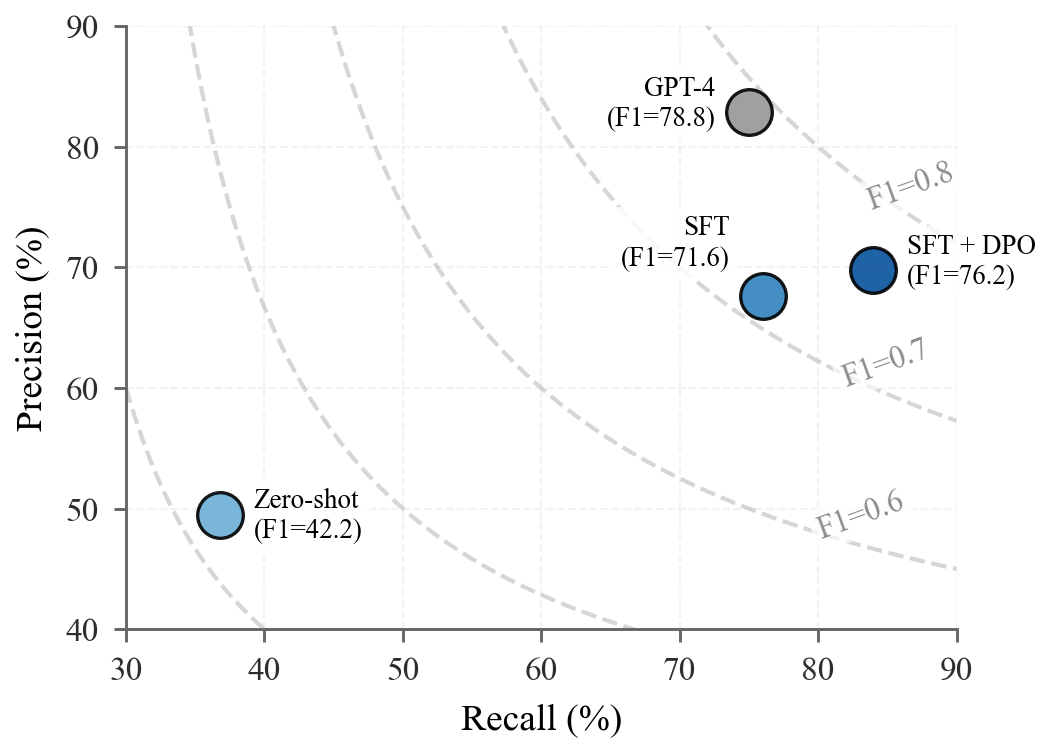

✓ Saved: fig_precision_recall.pdf/png

📊 Precision-Recall Trade-off Analysis:
  Zero-shot: Precision=49.5%, Recall=36.8%, F1=42.2%
  SFT: Precision=67.6%, Recall=76.0%, F1=71.6%
  SFT + DPO: Precision=69.8%, Recall=84.0%, F1=76.2%
  GPT-4: Precision=82.9%, Recall=75.0%, F1=78.8%

  Key Insight:
    • SFT: High recall (76.0%) but moderate precision (67.6%)
    • DPO: Improves both precision (+2.1 pp) and recall (+8.0 pp)
    • DPO sharpens decision boundary without trading off recall


In [170]:
# Precision-Recall Trade-off on IAC-V2
# SFT exhibits high recall but moderate precision; 
# DPO increases both metrics simultaneously, sharpening the decision boundary without trading off recall

if results and 'models' in results:
    models_df_pr = pd.DataFrame(results['models'])
    
    # Include all models including GPT-4
    order = ['Base Model (Zero-shot)', 'SFT Model (GEN)', 'DPO Model (GEN Enhanced)', 'gpt-4 (Zero-shot)']
    models_df_pr = models_df_pr[models_df_pr['model_name'].isin(order)].copy()
    models_df_pr['sort_order'] = models_df_pr['model_name'].apply(lambda x: order.index(x))
    models_df_pr = models_df_pr.sort_values('sort_order').reset_index(drop=True)
    
    # Clean model names
    name_mapping_pr = {
        'Base Model (Zero-shot)': 'Zero-shot',
        'SFT Model (GEN)': 'SFT',
        'DPO Model (GEN Enhanced)': 'SFT + DPO',
        'gpt-4 (Zero-shot)': 'GPT-4'
    }
    models_df_pr['clean_name'] = models_df_pr['model_name'].map(name_mapping_pr)
    
    # Extract precision and recall
    precisions = models_df_pr['precision'].values * 100
    recalls = models_df_pr['recall'].values * 100
    f1_scores_pr = models_df_pr['f1_score'].values * 100
    labels_pr = models_df_pr['clean_name'].values
    
    # Create figure - IEEE two-column format
    fig_pr, ax = plt.subplots(figsize=(3.5, 2.5))
    
    # Add F1 iso-contours first (so they appear behind points) - more visible
    recall_range = np.linspace(0.3, 0.9, 200)
    for f1_val in [0.4, 0.5, 0.6, 0.7, 0.8]:
        # F1 = 2PR/(P+R) => P = F1*R/(2R - F1)
        precision_f1_line = (f1_val * recall_range) / (2 * recall_range - f1_val)
        valid_mask = (precision_f1_line > 0) & (precision_f1_line <= 1) & (recall_range > f1_val/2)
        
        if valid_mask.any():
            # More visible F1 lines
            ax.plot(recall_range[valid_mask] * 100, precision_f1_line[valid_mask] * 100,
                   '--', color='#bbbbbb', alpha=0.6, linewidth=1.0, zorder=1)
            
            # Label F1 contours - only 0.6, 0.7, 0.8
            if f1_val in [0.6, 0.7, 0.8]:
                # Position label at the end of the line
                end_idx = int(len(recall_range[valid_mask]) * 0.85)
                if end_idx < len(recall_range[valid_mask]):
                    label_x = recall_range[valid_mask][end_idx] * 100
                    label_y = precision_f1_line[valid_mask][end_idx] * 100
                    ax.text(label_x, label_y, f'F1={f1_val:.1f}', 
                           fontsize=7.5, color='#777777', fontweight='medium',
                           ha='center', va='bottom', alpha=0.85, rotation=20,
                           bbox=dict(boxstyle='round,pad=0.2', 
                                   facecolor='white', edgecolor='none', alpha=0.7))
    
    # Color scheme matching model comparison: blues for Qwen variants, gray for GPT-4
    colors_pr = ['#6baed6', '#3182bd', '#08519c', '#969696']
    
    # Plot points with circles for all models
    for i, (prec, rec, f1, label, color) in enumerate(zip(precisions, recalls, f1_scores_pr, labels_pr, colors_pr)):
        ax.scatter(rec, prec, s=120, color=color, marker='o',
                  edgecolor='black', linewidth=0.8, zorder=5, alpha=0.9)
        
        # Add labels with slight offset to avoid overlap
        if i == 0:  # Zero-shot (bottom left) - move to right
            offset_x, offset_y = 8, 0
            ha, va = 'left', 'center'
        elif i == 1:  # SFT (middle)
            offset_x, offset_y = -8, 6
            ha, va = 'right', 'bottom'
        elif i == 2:  # DPO (top right)
            offset_x, offset_y = 8, 2
            ha, va = 'left', 'center'
        else:  # GPT-4 (highest precision)
            offset_x, offset_y = -8, 2
            ha, va = 'right', 'center'
        
        ax.annotate(f'{label}\n(F1={f1:.1f})', 
                   xy=(rec, prec),
                   xytext=(offset_x, offset_y),
                   textcoords='offset points',
                   fontsize=6.5, ha=ha, va=va,
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor='white', edgecolor='none', alpha=0.85),
                   zorder=6, fontweight='normal')
    
    # Styling
    ax.set_xlabel('Recall (%)', fontsize=9)
    ax.set_ylabel('Precision (%)', fontsize=9)
    ax.set_xlim(30, 90)
    ax.set_ylim(40, 90)
    
    # Grid
    ax.grid(True, linestyle='--', alpha=0.25, linewidth=0.5, zorder=0, color='#cccccc')
    ax.set_axisbelow(True)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.7)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_linewidth(0.7)
    ax.spines['bottom'].set_color('#666666')
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=8, width=0.7, 
                   length=3, color='#666666', labelcolor='#2d2d2d')
    
    plt.tight_layout(pad=0.3)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_precision_recall.pdf', 
                format='pdf', bbox_inches='tight', dpi=600)
    plt.savefig(PROJECT_ROOT / 'visualizations' / 'fig_precision_recall.png', 
                dpi=600, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: fig_precision_recall.pdf/png")
    
    # Print analysis
    print(f"\n📊 Precision-Recall Trade-off Analysis:")
    for i, (label, prec, rec, f1) in enumerate(zip(labels_pr, precisions, recalls, f1_scores_pr)):
        print(f"  {label}: Precision={prec:.1f}%, Recall={rec:.1f}%, F1={f1:.1f}%")
    
    print(f"\n  Key Insight:")
    print(f"    • SFT: High recall ({recalls[1]:.1f}%) but moderate precision ({precisions[1]:.1f}%)")
    print(f"    • DPO: Improves both precision (+{precisions[2]-precisions[1]:.1f} pp) and recall (+{recalls[2]-recalls[1]:.1f} pp)")
    print(f"    • DPO sharpens decision boundary without trading off recall")